In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Age and Gender Classification

 The task of this work is to make one model that does both: age and gender classification from given photo. I will also need to analyze the model from the ethical point of view and see what sort of dangers and caveats such models can have.

Concepts to explore:
- Classification task;
- Convolutional neural network;
- AI ethics and bias;
- Model interpretability.

Requirements:
- Standard cycle of EDA-model-evaluation;
- Create a single model that returns age and gender in a single pass;
- Analyze model performance;
- Understand, which are the best/worst performing samples;
- Use LIME for model interpretability with images.

The dataset source:
https://www.kaggle.com/jangedoo/utkface-new


In [4]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=cf5b3484a373fb09eff67d114fc3d6699fdb04916767aedda7bccbca41fa2509
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [5]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
from torch.nn import Sigmoid
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import AdamW, RMSprop
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    mean_absolute_error,
)
from lime import lime_image as lime_image_module
from skimage.segmentation import mark_boundaries

## Used Functions:

In [6]:
def get_image_dimensions(image_path:str):
    """function to return single image size and chanel number"""
    with Image.open(image_path) as img:
        width, height = img.size
        channels = len(img.getbands())
    return width, height, channels

In [23]:
def get_color_mode(image_path:str):
    """function to get Image color mode"""
    try:
        with Image.open(image_path) as img:
            return img.mode
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [7]:
def get_image_channels(image_path:str):
    """
    function splits the image into its color channels and
    converts channels to numpy arrays.
    """
    try:
        with Image.open(image_path) as img:
            red, green, blue = img.split()
            red_array = np.array(red).ravel()
            green_array = np.array(green).ravel()
            blue_array = np.array(blue).ravel()

            return red_array, green_array, blue_array

    except Exception as e:
        print(f"Error processing image at {image_path}: {e}")
        return None, None, None

In [8]:
def calculate_color_histogram(image):
    """Function to calculate color histogram for an image"""
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],
                        [0, 256, 0, 256, 0, 256])
    hist = hist / hist.sum()
    return hist.flatten()

In [9]:
def image_color_grayscale(image_path, saturation_threshold=20):
    """
    Function to find grayscale images.

    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            return False, image_path

        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
        _, saturation, _ = cv2.split(hsv)

        is_grayscale = saturation.mean() < saturation_threshold
        return is_grayscale, image_path

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return False, image_path

In [10]:
def are_images_equal(img1, img2):
    """Check if the images have the same shape"""
    if img1.shape != img2.shape:
        return False
    return np.array_equal(img1, img2)

In [11]:
def find_duplicate_grayscale_images(image_list):
    """
    Function to find duplicated grayscale images and return separate dataframe.
    """
    duplicates = []
    for i, filename_i in tqdm(
        enumerate(image_list),
        desc="Checking Grayscale Duplicates",
        total=len(image_list),
    ):
        img_i = cv2.imread(filename_i, cv2.IMREAD_GRAYSCALE)

        # Compare with subsequent images in the list
        for j, filename_j in enumerate(image_list[i + 1 :], start=i + 1):
            img_j = cv2.imread(filename_j, cv2.IMREAD_GRAYSCALE)

            if are_images_equal(img_i, img_j):
                duplicates.append((filename_i, filename_j))
    if duplicates:
        duplicate_grayscale_df = pd.DataFrame(
            duplicates,
            columns=["Image1", "Image2"]
            )
        print("Duplicate Grayscale Images:")
        print(duplicate_grayscale_df.head())
        return duplicate_grayscale_df
    else:
        print("No duplicates found based on color histograms.")
        return pd.DataFrame()

    return duplicate_grayscale_df

In [12]:
def histogram_intersection(hist1, hist2):
    """
    function takes two histograms, converts them to NumPy arrays,
     calculates the histogram intersection and returns the resulting
     intersection value. A higher intersection value indicates greater
     similarity between the two histograms.
    """
    hist1_np = np.array(hist1, dtype=np.float32)
    hist2_np = np.array(hist2, dtype=np.float32)
    return cv2.compareHist(hist1_np, hist2_np, cv2.HISTCMP_INTERSECT)

In [13]:
def batch_image_processing(image_paths, df, threshold=0.9, batch_size=100):
    """
    divides the input list of image paths into batches and processes each batch
    separately. Within each batch, the function uses a nested loop to compare
     all images against each other. Returns the DataFrame with duplicate
     information.
    """
    num_images = len(image_paths)
    batches = (num_images + batch_size - 1) // batch_size

    duplicates = []

    for batch_num in tqdm(range(batches), desc="Processing Batches"):
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, num_images)

        batch_image_paths = image_paths[start_idx:end_idx]

        for i in range(len(batch_image_paths)):
            for j in range(i + 1, len(batch_image_paths)):
                img1_path = batch_image_paths[i]
                img2_path = batch_image_paths[j]

                hist1 = df[df['Images'] == img1_path]['Color_Histogram'].iloc[0]
                hist2 = df[df['Images'] == img2_path]['Color_Histogram'].iloc[0]

                hist1 = np.fromstring(hist1[1:-1], sep=' ', dtype=np.float32)
                hist2 = np.fromstring(hist2[1:-1], sep=' ', dtype=np.float32)

                intersection = histogram_intersection(hist1, hist2)

                if intersection > threshold:
                    duplicates.append((img1_path, img2_path))

    if duplicates:
        color_duplicate_df = pd.DataFrame(
            duplicates, columns=['Image1', 'Image2'])
        print("Duplicate Color Images:")
        print(color_duplicate_df.head())
        return color_duplicate_df
    else:
        print("No duplicates found based on color histograms.")
        return pd.DataFrame()

In [14]:
def plot_random_pairs(duplicate_df, num_pairs_to_plot):
    """function to plot random image pairs"""
    random_indices = random.sample(range(len(duplicate_df)), num_pairs_to_plot)
    for index in random_indices:
        row = duplicate_df.iloc[index]

        img1 = mpimg.imread(row["Image1"])
        plt.subplot(num_pairs_to_plot, 2, 2 *
                    (random_indices.index(index) + 1) - 1)
        plt.imshow(img1)
        plt.title(f"Image {random_indices.index(index) + 1} (1)")
        plt.axis("off")

        img2 = mpimg.imread(row["Image2"])
        plt.subplot(num_pairs_to_plot, 2, 2 *
                     (random_indices.index(index) + 1))
        plt.imshow(img2)
        plt.title(f"Image {random_indices.index(index) + 1} (2)")
        plt.axis("off")

## EDA Part

In [16]:
path = "/content/drive/MyDrive/Face_data/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
files[0]

Total samples: 23708


'86_0_1_20170120230044602.jpg.chip.jpg'

There are 23708 images in this dataset. The image title with annotations of age, gender, and ethnicity. For our work I will need age and gender annotations.<br>
**Age** :is a Positive Integer, denoting age of person <br>
**Gender** :is denoted by 1(female) or 0(male) <br>
**Ethnicity** :is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others.

So, for EDA purposes I make a dataframe that will contain separated image_path, age and gender features:

In [17]:
images = []
age = []
gender = []

for file in tqdm(files):
    split = file.split('_')
    age.append(int(split[0]))
    gender.append(int(split[1]))
    image_path = os.path.join(path, file)
    img = Image.open(image_path)
    images.append(img)

100%|██████████| 23708/23708 [4:33:36<00:00,  1.44it/s]


In [18]:
image_paths = [os.path.join(path, file) for file in files]

images_series = pd.Series(image_paths, name='Images')
ages_series = pd.Series(age, name='Age')
genders_series = pd.Series(gender, name='Gender')

df = pd.concat([images_series, ages_series, genders_series], axis=1)
df.head()

Images  Age  Gender
0  /content/drive/MyDrive/Face_data/UTKFace/86_0_...   86       0
1  /content/drive/MyDrive/Face_data/UTKFace/80_0_...   80       0
2  /content/drive/MyDrive/Face_data/UTKFace/9_0_0...    9       0
3  /content/drive/MyDrive/Face_data/UTKFace/72_1_...   72       1
4  /content/drive/MyDrive/Face_data/UTKFace/7_1_3...    7       1

Printing out 16 random images:

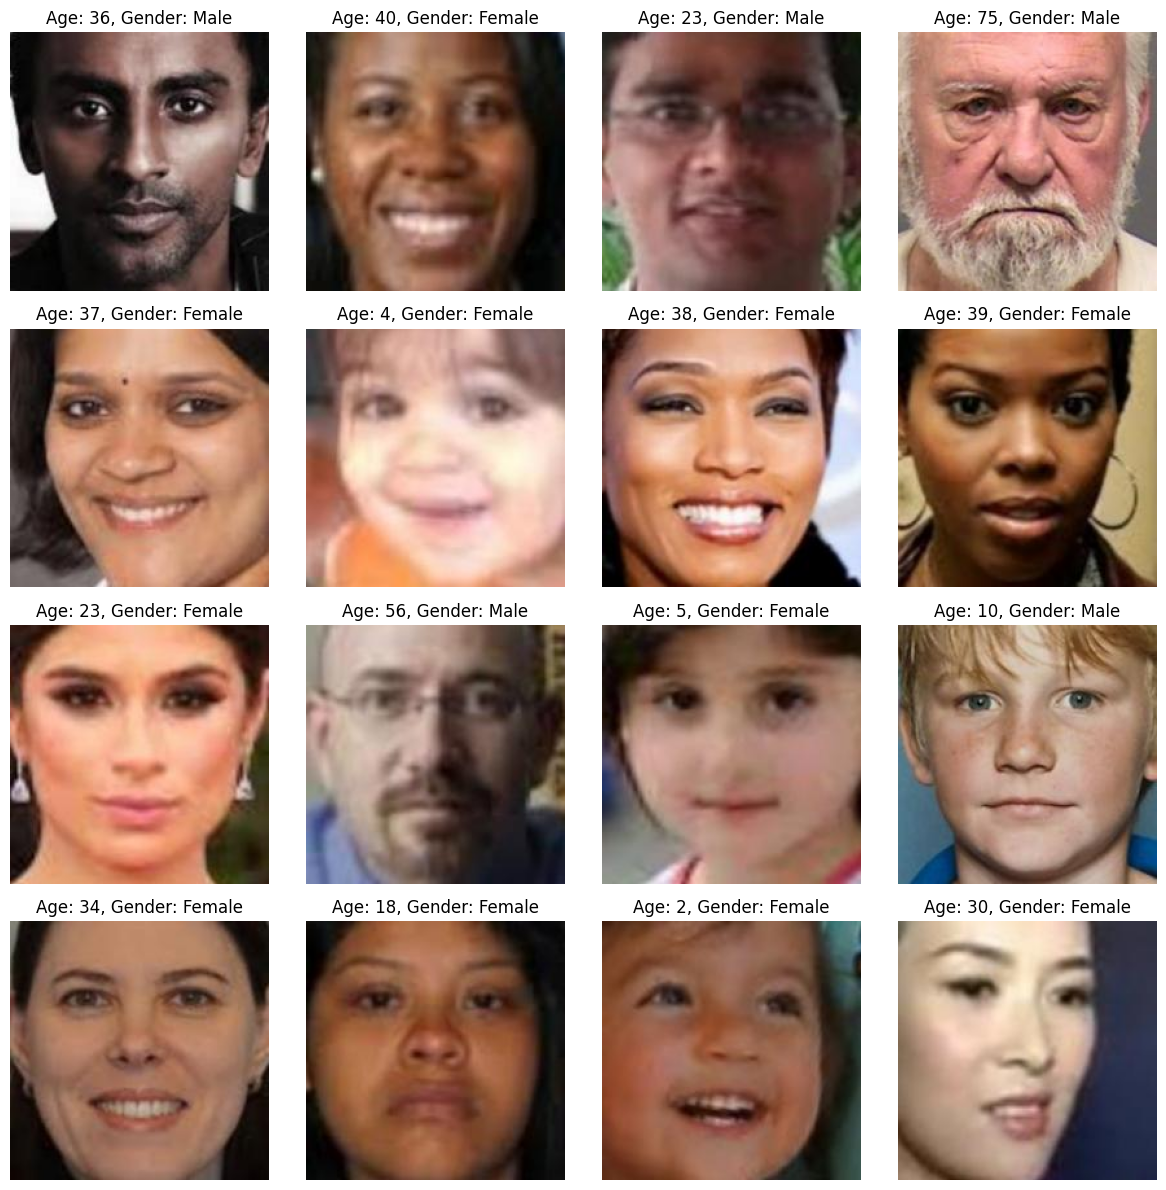

In [19]:
random_indices = np.random.choice(df.index, size=16, replace=False)
sample_df = df.loc[random_indices]

plt.figure(figsize=(12, 12))
for i, row in enumerate(sample_df.itertuples(), 1):
    plt.subplot(4, 4, i)
    img = Image.open(os.path.join(path, row.Images))
    plt.imshow(img)
    gender_label = "Male" if row.Gender == 0 else "Female"
    plt.title(f"Age: {row.Age}, Gender: {gender_label}")

    plt.axis('off')

plt.tight_layout()
plt.show()

Checking dataset image formats:
* result: all images are .jpg format

In [20]:
image_formats = set()
for root, dirs, files in os.walk(path):
    for file in files:
        _, extension = os.path.splitext(file)
        image_formats.add(extension.lower())

print("Image formats in the dataset:", image_formats)

Image formats in the dataset: {'.jpg'}


Checking the size and cnannel number of dataset images:
* result: as the describtion shows all images are of the same 200 x 200 size and all are of the 3 channels, that refers to the individual color components. Each channel corresponds to the intensity of one of these primary colors.

In [21]:
image_shape_df = pd.DataFrame()
image_shape_df[["Width", "Height", "Channels"]] = df["Images"].apply(
    lambda path: pd.Series(get_image_dimensions(path))
)
image_shape_df.head(15)

Width  Height  Channels
0     200     200         3
1     200     200         3
2     200     200         3
3     200     200         3
4     200     200         3
5     200     200         3
6     200     200         3
7     200     200         3
8     200     200         3
9     200     200         3
10    200     200         3
11    200     200         3
12    200     200         3
13    200     200         3
14    200     200         3

In [ ]:
image_shape_df.describe()

Width   Height  Channels
count  23708.0  23708.0   23708.0
mean     200.0    200.0       3.0
std        0.0      0.0       0.0
min      200.0    200.0       3.0
25%      200.0    200.0       3.0
50%      200.0    200.0       3.0
75%      200.0    200.0       3.0
max      200.0    200.0       3.0

*Let's check the image color mode:

In [27]:
df['Color_Mode'] = df['Images'].apply(get_color_mode)
df.head()

Images  Age  Gender Color_Mode
0  /content/drive/MyDrive/Face_data/UTKFace/86_0_...   86       0        RGB
1  /content/drive/MyDrive/Face_data/UTKFace/80_0_...   80       0        RGB
2  /content/drive/MyDrive/Face_data/UTKFace/9_0_0...    9       0        RGB
3  /content/drive/MyDrive/Face_data/UTKFace/72_1_...   72       1        RGB
4  /content/drive/MyDrive/Face_data/UTKFace/7_1_3...    7       1        RGB

So, I have added the individual channels to my data table, with the relative names "red", "green" and "blue".

In [28]:
image_channels_df = pd.DataFrame()
image_channels_df[['Red', 'Green', 'Blue']] = df['Images'].apply(
    lambda path: pd.Series(get_image_channels(path))
    )
df_combined = pd.concat([df, image_channels_df], axis=1)
df_combined.head()

Images  Age  Gender Color_Mode  \
0  /content/drive/MyDrive/Face_data/UTKFace/86_0_...   86       0        RGB   
1  /content/drive/MyDrive/Face_data/UTKFace/80_0_...   80       0        RGB   
2  /content/drive/MyDrive/Face_data/UTKFace/9_0_0...    9       0        RGB   
3  /content/drive/MyDrive/Face_data/UTKFace/72_1_...   72       1        RGB   
4  /content/drive/MyDrive/Face_data/UTKFace/7_1_3...    7       1        RGB   

                                                 Red  \
0  [27, 24, 25, 30, 40, 52, 73, 90, 107, 116, 128...   
1  [138, 140, 142, 144, 144, 145, 148, 150, 161, ...   
2  [110, 105, 110, 95, 74, 94, 107, 76, 87, 104, ...   
3  [167, 165, 163, 159, 159, 158, 160, 160, 156, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                               Green  \
0  [24, 21, 20, 25, 33, 45, 63, 80, 93, 103, 112,...   
1  [142, 144, 146, 148, 148, 150, 153, 155, 162, ...   
2  [79, 74, 79, 64, 43, 63, 76, 45, 56, 73, 84, 8...   
3  [186, 184, 180, 177, 172, 172, 170, 171, 163, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                Blue  
0  [19, 16, 14, 19, 25, 35, 54, 68, 82, 87, 97, 1...  
1  [154, 156, 157, 159, 157, 156, 159, 158, 166, ...  
2  [74, 69, 74, 59, 38, 58, 71, 40, 51, 68, 79, 7...  
3  [203, 201, 196, 191, 188, 183, 180, 177, 169, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

For my search for duplications I need to calculate image color histogram. The color histogram represents the distribution of colors in an image and I will use it as a feature for image analysis and comparison:

In [29]:
df_combined['Color_Histogram'] = df_combined['Images'].apply(
    lambda path: calculate_color_histogram(cv2.imread(path))
    )

In [30]:
df_combined.head()

Images  Age  Gender Color_Mode  \
0  /content/drive/MyDrive/Face_data/UTKFace/86_0_...   86       0        RGB   
1  /content/drive/MyDrive/Face_data/UTKFace/80_0_...   80       0        RGB   
2  /content/drive/MyDrive/Face_data/UTKFace/9_0_0...    9       0        RGB   
3  /content/drive/MyDrive/Face_data/UTKFace/72_1_...   72       1        RGB   
4  /content/drive/MyDrive/Face_data/UTKFace/7_1_3...    7       1        RGB   

                                                 Red  \
0  [27, 24, 25, 30, 40, 52, 73, 90, 107, 116, 128...   
1  [138, 140, 142, 144, 144, 145, 148, 150, 161, ...   
2  [110, 105, 110, 95, 74, 94, 107, 76, 87, 104, ...   
3  [167, 165, 163, 159, 159, 158, 160, 160, 156, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                               Green  \
0  [24, 21, 20, 25, 33, 45, 63, 80, 93, 103, 112,...   
1  [142, 144, 146, 148, 148, 150, 153, 155, 162, ...   
2  [79, 74, 79, 64, 43, 63, 76, 45, 56, 73, 84, 8...   
3  [186, 184, 180, 177, 172, 172, 170, 171, 163, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                Blue  \
0  [19, 16, 14, 19, 25, 35, 54, 68, 82, 87, 97, 1...   
1  [154, 156, 157, 159, 157, 156, 159, 158, 166, ...   
2  [74, 69, 74, 59, 38, 58, 71, 40, 51, 68, 79, 7...   
3  [203, 201, 196, 191, 188, 183, 180, 177, 169, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                     Color_Histogram  
0  [0.0982, 0.0165, 0.0004, 0.0, 0.0, 0.0, 0.0, 0...  
1  [0.0115, 0.002775, 0.000525, 0.0, 0.0, 0.0, 0....  
2  [0.005925, 0.0218, 0.00405, 0.0002, 0.0, 0.0, ...  
3  [0.001075, 0.015825, 0.0035, 0.0, 0.0, 0.0, 0....  
4  [0.226325, 0.061625, 0.003625, 5e-05, 0.0, 0.0...

Next find out if there are any images with incorrect title. These images will be deleted from my dataframe:

In [31]:
bad_images = []

for image in df["Images"]:
    im_bad_name = image.split('_')[-1].split('.')
    parts_after_last_underscore = image.split('/')[-1].split('_')
    if len(im_bad_name)!= 4 or len(parts_after_last_underscore) != 4:
        bad_images.append(image)

# Display the list of bad images
print("List of bad images:")
print(bad_images)

List of bad images:
['/content/drive/MyDrive/Face_data/UTKFace/61_1_20170109150557335.jpg.chip.jpg', '/content/drive/MyDrive/Face_data/UTKFace/61_1_20170109142408075.jpg.chip.jpg', '/content/drive/MyDrive/Face_data/UTKFace/55_0_0_20170116232725357jpg.chip.jpg', '/content/drive/MyDrive/Face_data/UTKFace/39_1_20170116174525125.jpg.chip.jpg']


In [32]:
df_combined = df_combined[~df_combined["Images"].isin(bad_images)].reset_index(
    drop=True
)

Saving the correct dataframe:

In [33]:
df_combined.to_csv('/content/drive/MyDrive/data/df_combined.csv', index=False)


In [ ]:
df_combined = pd.read_csv('/content/drive/MyDrive/data/df_combined.csv')

In [34]:
df_combined.head()

Images  Age  Gender Color_Mode  \
0  /content/drive/MyDrive/Face_data/UTKFace/86_0_...   86       0        RGB   
1  /content/drive/MyDrive/Face_data/UTKFace/80_0_...   80       0        RGB   
2  /content/drive/MyDrive/Face_data/UTKFace/9_0_0...    9       0        RGB   
3  /content/drive/MyDrive/Face_data/UTKFace/72_1_...   72       1        RGB   
4  /content/drive/MyDrive/Face_data/UTKFace/7_1_3...    7       1        RGB   

                                                 Red  \
0  [27, 24, 25, 30, 40, 52, 73, 90, 107, 116, 128...   
1  [138, 140, 142, 144, 144, 145, 148, 150, 161, ...   
2  [110, 105, 110, 95, 74, 94, 107, 76, 87, 104, ...   
3  [167, 165, 163, 159, 159, 158, 160, 160, 156, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                               Green  \
0  [24, 21, 20, 25, 33, 45, 63, 80, 93, 103, 112,...   
1  [142, 144, 146, 148, 148, 150, 153, 155, 162, ...   
2  [79, 74, 79, 64, 43, 63, 76, 45, 56, 73, 84, 8...   
3  [186, 184, 180, 177, 172, 172, 170, 171, 163, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                Blue  \
0  [19, 16, 14, 19, 25, 35, 54, 68, 82, 87, 97, 1...   
1  [154, 156, 157, 159, 157, 156, 159, 158, 166, ...   
2  [74, 69, 74, 59, 38, 58, 71, 40, 51, 68, 79, 7...   
3  [203, 201, 196, 191, 188, 183, 180, 177, 169, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                     Color_Histogram  
0  [0.0982, 0.0165, 0.0004, 0.0, 0.0, 0.0, 0.0, 0...  
1  [0.0115, 0.002775, 0.000525, 0.0, 0.0, 0.0, 0....  
2  [0.005925, 0.0218, 0.00405, 0.0002, 0.0, 0.0, ...  
3  [0.001075, 0.015825, 0.0035, 0.0, 0.0, 0.0, 0....  
4  [0.226325, 0.061625, 0.003625, 5e-05, 0.0, 0.0...

Next task is to find duplicated images. My initial approach to find duplications did not work, because grayscale was not very well recognized. Since there are grayscale and color images I will need to separate those. One common approach is to check the saturation of the image. Grayscale images have no saturation since they contain only shades of gray, while color images have varying saturation levels. I used a threshold on the saturation value to classify images. So I create separate dataframes for grayscale and color images to indicate the duplications:

In [ ]:
all_images = df_combined["Images"].tolist()
grayscale_images = []
color_images = []

for is_grayscale, image_path in tqdm(
    map(image_color_grayscale, all_images),
    total=len(all_images),
    desc="Checking Images",
):
    if is_grayscale:
        grayscale_images.append(image_path)
    else:
        color_images.append(image_path)

* Result: We have got the dataframe with 8 pairs of grayscale images that are duplicated, and also, based on image titles we can identify tha images were mislabeled. So for future I will keep only first image of pair.

In [ ]:
grayscale_duplicates_df = find_duplicate_grayscale_images(grayscale_images)
grayscale_duplicates_df.shape

Checking Grayscale Duplicates: 100%|██████████| 765/765 [22:47<00:00,  1.79s/it]


Duplicate Grayscale Images:
                                              Image1  \
0  /content/drive/MyDrive/Face_data/UTKFace/67_0_...   
1  /content/drive/MyDrive/Face_data/UTKFace/63_0_...   
2  /content/drive/MyDrive/Face_data/UTKFace/58_0_...   
3  /content/drive/MyDrive/Face_data/UTKFace/58_0_...   
4  /content/drive/MyDrive/Face_data/UTKFace/28_0_...   

                                              Image2  
0  /content/drive/MyDrive/Face_data/UTKFace/54_0_...  
1  /content/drive/MyDrive/Face_data/UTKFace/63_0_...  
2  /content/drive/MyDrive/Face_data/UTKFace/58_0_...  
3  /content/drive/MyDrive/Face_data/UTKFace/47_0_...  
4  /content/drive/MyDrive/Face_data/UTKFace/28_1_...  


(8, 2)

In [ ]:
grayscale_duplicates_df.head()

Image1  \
0  /content/drive/MyDrive/Face_data/UTKFace/67_0_...   
1  /content/drive/MyDrive/Face_data/UTKFace/63_0_...   
2  /content/drive/MyDrive/Face_data/UTKFace/58_0_...   
3  /content/drive/MyDrive/Face_data/UTKFace/58_0_...   
4  /content/drive/MyDrive/Face_data/UTKFace/28_0_...   

                                              Image2  
0  /content/drive/MyDrive/Face_data/UTKFace/54_0_...  
1  /content/drive/MyDrive/Face_data/UTKFace/63_0_...  
2  /content/drive/MyDrive/Face_data/UTKFace/58_0_...  
3  /content/drive/MyDrive/Face_data/UTKFace/47_0_...  
4  /content/drive/MyDrive/Face_data/UTKFace/28_1_...

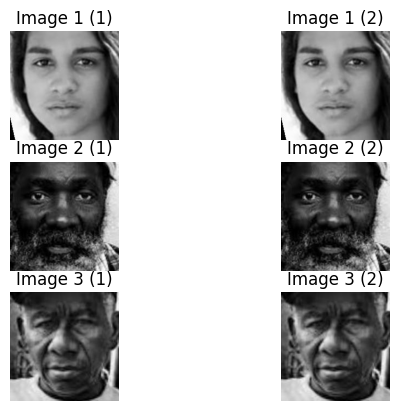

In [ ]:
plot_random_pairs(grayscale_duplicates_df, 3)

To find color image duplicates I had to separate them in batches to deal with memory issue, but I have managed to get dataframe with 55 pairs of duplicates. Again, I have left only the first image of the pair and reduced the amount of mislabeled images at the same time:

In [ ]:
color_duplicates_df = batch_image_processing(color_images, df_combined)


Processing Batches: 100%|██████████| 230/230 [1:34:07<00:00, 24.56s/it]

Duplicate Color Images:
                                              Image1  \
0  /content/drive/MyDrive/Face_data/UTKFace/88_1_...   
1  /content/drive/MyDrive/Face_data/UTKFace/51_0_...   
2  /content/drive/MyDrive/Face_data/UTKFace/35_0_...   
3  /content/drive/MyDrive/Face_data/UTKFace/36_0_...   
4  /content/drive/MyDrive/Face_data/UTKFace/34_0_...   

                                              Image2  
0  /content/drive/MyDrive/Face_data/UTKFace/75_1_...  
1  /content/drive/MyDrive/Face_data/UTKFace/55_0_...  
2  /content/drive/MyDrive/Face_data/UTKFace/35_0_...  
3  /content/drive/MyDrive/Face_data/UTKFace/39_0_...  
4  /content/drive/MyDrive/Face_data/UTKFace/34_0_...  


In [ ]:
color_duplicates_df.to_csv(
    "/content/drive/MyDrive/data/color_duplicates_df.csv", index=False
)

In [ ]:
color_duplicates_df = pd.read_csv(
    "/content/drive/MyDrive/data/color_duplicates_df.csv"
    )
print(color_duplicates_df.shape)
color_duplicates_df.head()

(55, 2)


Image1  \
0  /content/drive/MyDrive/Face_data/UTKFace/88_1_...   
1  /content/drive/MyDrive/Face_data/UTKFace/51_0_...   
2  /content/drive/MyDrive/Face_data/UTKFace/35_0_...   
3  /content/drive/MyDrive/Face_data/UTKFace/36_0_...   
4  /content/drive/MyDrive/Face_data/UTKFace/34_0_...   

                                              Image2  
0  /content/drive/MyDrive/Face_data/UTKFace/75_1_...  
1  /content/drive/MyDrive/Face_data/UTKFace/55_0_...  
2  /content/drive/MyDrive/Face_data/UTKFace/35_0_...  
3  /content/drive/MyDrive/Face_data/UTKFace/39_0_...  
4  /content/drive/MyDrive/Face_data/UTKFace/34_0_...

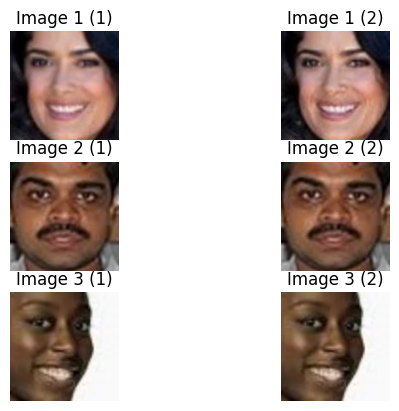

In [ ]:
plot_random_pairs(color_duplicates_df, 3)

Bellow is my final dataframe with droped duplicates. In total I am left with 23643 images:

In [ ]:
grayscale_list = grayscale_duplicates_df["Image2"].tolist()
df_combined = df_combined[~df_combined['Images'].isin(grayscale_list)]
df_combined = df_combined.reset_index(drop=True)

In [ ]:
color_list = color_duplicates_df["Image2"].tolist()
df_combined = df_combined[~df_combined['Images'].isin(color_list)]
df_combined = df_combined.reset_index(drop=True)

In [ ]:
df_combined.to_csv('/content/drive/MyDrive/data/df_final.csv', index=False)

In [ ]:
df_final = pd.read_csv('/content/drive/MyDrive/data/df_final.csv')

* **What is the the Age Distribution?**<br>

The age distribution of our data is from 1 to 116 years. The largest number of photos is around 29 years old:

count    23643.000000
mean        33.332826
std         19.880861
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: Age, dtype: float64


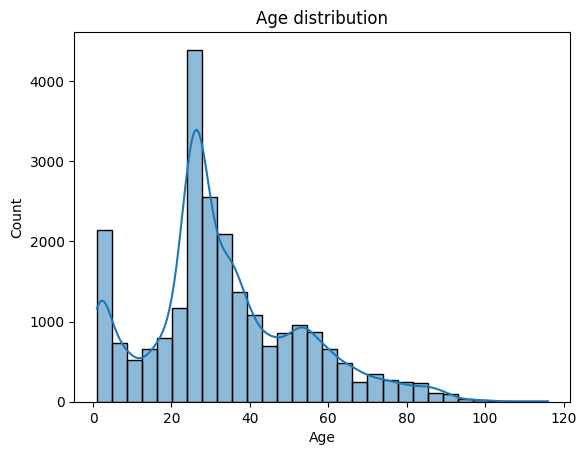

In [ ]:
print(df_final["Age"].describe())
sns.histplot(df_final['Age'],kde=True, bins=30)
plt.title("Age distribution")
plt.show()

* **What is the the Gender Distribution?**<br>

Our dataset identified 12356 images of male gender (indexed as 0) and 11287 images of female gender (indexed as 1).

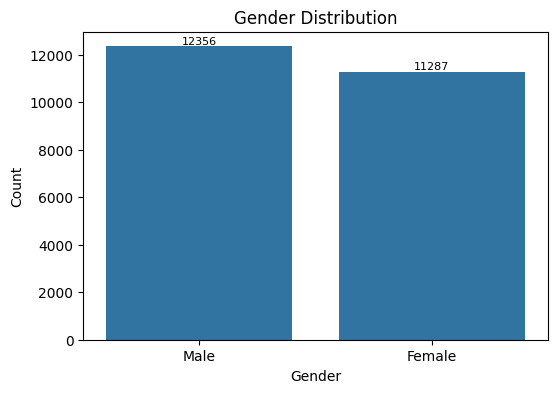

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Gender', data=df_final)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks([0, 1], ['Male', 'Female'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2,
                                      p.get_height()),

                ha='center', va='baseline', fontsize=8, color='black',
                 xytext=(0,1.5),
                textcoords='offset points')

plt.show()

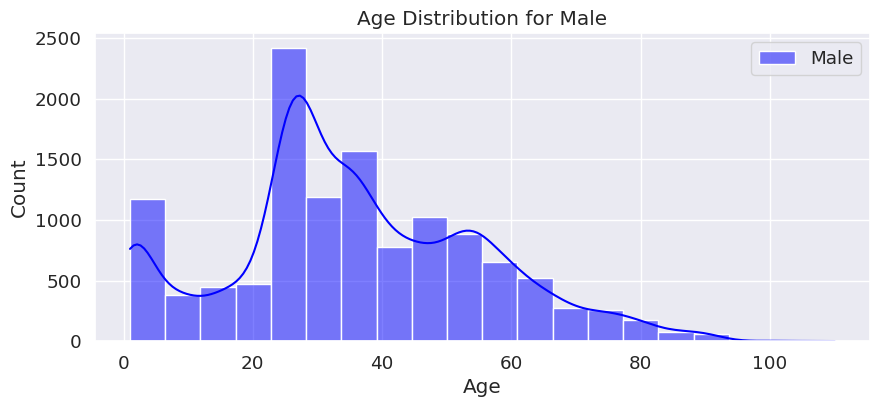

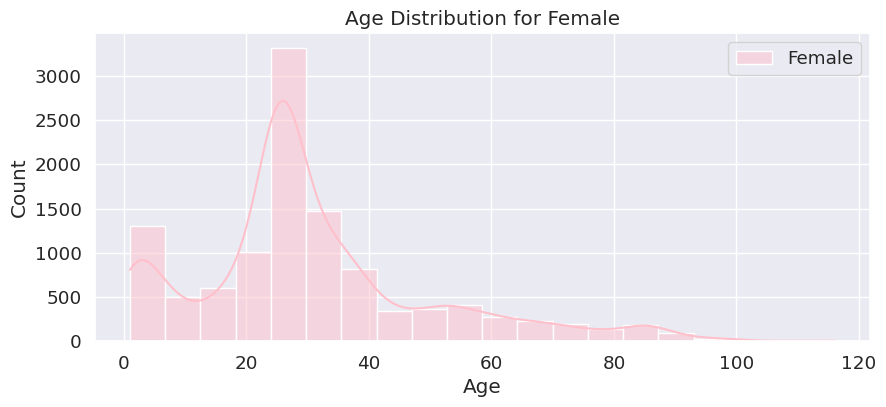

In [ ]:
male_data = df_final[df_final['Gender'] == 0]
female_data = df_final[df_final['Gender'] == 1]

plt.figure(figsize=(10,4))
sns.histplot(male_data['Age'], bins=20, kde=True, color='blue', label='Male')
plt.title('Age Distribution for Male')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(female_data['Age'], bins=20, kde=True,
             color='pink', label='Female')
plt.title('Age Distribution for Female')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
male_age_count = (
    df_final[df_final["Gender"] == 0]
    .groupby("Age")
    .size()
    .reset_index(name="MaleCount")
)
female_age_count = (
    df_final[df_final["Gender"] == 1]
    .groupby("Age")
    .size()
    .reset_index(name="FemaleCount")
)
age_count_df = pd.merge(male_age_count, female_age_count,
                        on="Age", how="outer").fillna(0)
age_count_df.T

0      1      2      3      4      5     6      7      8    \
Age            1.0    2.0    3.0    4.0    5.0    6.0   7.0    8.0    9.0   
MaleCount    635.0  225.0   97.0  108.0   78.0   29.0  59.0   67.0  136.0   
FemaleCount  472.0  253.0  192.0  165.0  118.0  102.0  80.0  196.0   30.0   

              9    ...    94     95     96     97    98    99    100    101  \
Age          10.0  ...  101.0  103.0  105.0  110.0  93.0  95.0  96.0  111.0   
MaleCount    91.0  ...    1.0    1.0    1.0    2.0   0.0   0.0   0.0    0.0   
FemaleCount  65.0  ...    1.0    0.0    4.0    3.0   5.0   9.0  17.0    1.0   

               102    103  
Age          115.0  116.0  
MaleCount      0.0    0.0  
FemaleCount    3.0    4.0  

[3 rows x 104 columns]

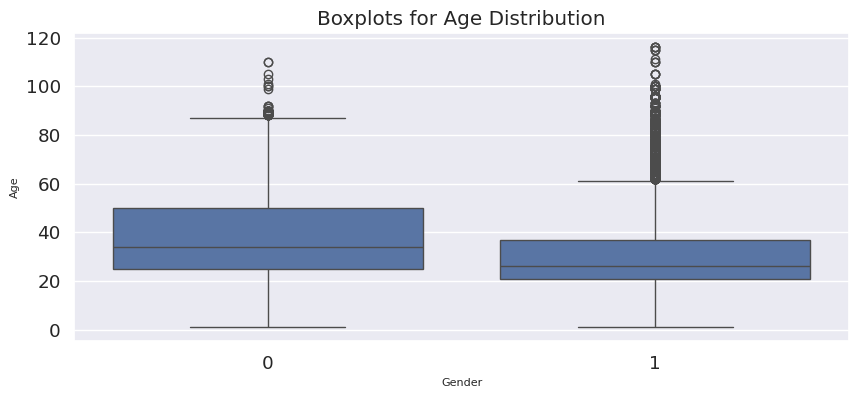

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df_final["Gender"], y=df_final["Age"])
plt.ylabel("Age", fontsize=8)
plt.xlabel("Gender", fontsize=8)
plt.title("Boxplots for Age Distribution")

plt.show()

For future dataset split for training I will keep only images that in age-gender count is greater than 1. To assure that both gender groups reflects the same age:

In [ ]:
age_gender_counts = df_final.groupby(["Age", "Gender"]).size()
filtered_df = (
    df_final.set_index(["Age", "Gender"])
    .loc[age_gender_counts[age_gender_counts > 1].index]
    .reset_index()
)

filtered_df.shape

(23635, 7)

In [ ]:
filtered_df.to_csv('/content/drive/MyDrive/data/filtered_df.csv', index=False)

In [ ]:
filtered_df = pd.read_csv('/content/drive/MyDrive/data/filtered_df.csv')

In [ ]:
filtered_df = filtered_df.astype({'Age': 'float32', 'Gender': 'int32'})

## Model related functions:

In [ ]:
def evaluate_model_on_validation_set(
    model, validation_dataloader, age_criterion, gender_criterion, device):
    """for model evaluation on validation data"""
    model.eval()
    batch_val_age_losses = []
    batch_val_gender_losses = []

    with torch.no_grad():
        for data in tqdm(validation_dataloader):
            val_inputs = data["image"].to(device)
            val_age_labels = data["age"].to(device)
            val_gender_labels = data["gender"].to(device)

            val_age_outputs, val_gender_outputs = model(val_inputs)
            val_age_loss = age_criterion(
                val_age_outputs, val_age_labels.unsqueeze(1).float()
            )
            val_gender_loss = gender_criterion(
                val_gender_outputs, val_gender_labels.unsqueeze(1).float()
            )
            batch_val_age_losses.append(val_age_loss.item())
            batch_val_gender_losses.append(val_gender_loss.item())

    average_val_age_loss = sum(batch_val_age_losses) / len(batch_val_age_losses)
    average_val_gender_loss = sum(batch_val_gender_losses) / len(
        batch_val_gender_losses
    )

    print(f"Validation Loss (Age) (L1): {average_val_age_loss:.4f},"
    f"Validation Loss (Gender): {average_val_gender_loss:.4f}")

    return average_val_age_loss, average_val_gender_loss

In [ ]:
def checkpoint_model(
    model,
    optimizer,
    scheduler,
    best_epoch,
    best_val_loss,
    average_val_age_loss,
    average_val_gender_loss,
    val_age_losses,
    val_gender_losses,
    checkpoint_path
):
    """Checkpoints the model and related training information."""
    checkpoint = {
        "epoch": best_epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "best_val_age_gender_loss": best_val_loss,
        "average_val_age_loss": average_val_age_loss,
        "average_val_gender_loss": average_val_gender_loss,
        "val_age_losses": val_age_losses,
        "val_gender_losses": val_gender_losses,
    }
    torch.save(checkpoint, checkpoint_path)

In [ ]:
def plot_losses_both(
    train_age_losses, train_gender_losses, val_age_losses, val_gender_losses
):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    axes[0].plot(train_age_losses, label="Training Age")
    axes[0].plot(val_age_losses, label="Validation Age")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Age Loss (L1)")
    axes[0].set_title("Age Losses")
    axes[0].legend()

    axes[1].plot(train_gender_losses, label="Training")
    axes[1].plot(val_gender_losses, label="Validation")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Gender Loss")
    axes[1].set_title("Gender Losses")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def train_nn(
    model,
    train_dataloader,
    optimizer,
    age_criterion,
    gender_criterion,
    scheduler,
    device,
    num_epochs,
    checkpoint_path,
    patience=2):
    train_age_losses = []
    train_gender_losses = []
    val_age_losses = []
    val_gender_losses = []

    early_stopping_counter = 0
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        batch_train_age_losses = []
        batch_train_gender_losses = []

        print("********** Training process started **********")
        for batch_idx, data in enumerate(
            tqdm(train_dataloader,
                 desc=f"Epoch {epoch + 1}/{num_epochs} - Training")
        ):
            inputs = data["image"].to(device)
            age_labels = data["age"].to(device)
            gender_labels = data["gender"].to(device)

            optimizer.zero_grad()

            age_outputs, gender_outputs = model(inputs)

            age_loss = age_criterion(
                age_outputs, age_labels.unsqueeze(1).float()
            )
            gender_loss = gender_criterion(
                gender_outputs, gender_labels.unsqueeze(1).float()
            )

            loss = age_loss + gender_loss
            loss.backward()

            optimizer.step()

            batch_train_age_losses.append(age_loss.item())
            batch_train_gender_losses.append(gender_loss.item())
            if (batch_idx + 1) % 200 == 0:
                print(
                    f"Training Batch {batch_idx + 1} / {len(train_dataloader)}"
                    f" - Age Loss L1: {age_loss.item():.4f}"
                    f" - Gender Loss: {gender_loss.item():.4f}"
                )

        average_train_age_loss = sum(batch_train_age_losses) / len(
            batch_train_age_losses
        )
        average_train_gender_loss = sum(batch_train_gender_losses) / len(
            batch_train_gender_losses
        )

        train_age_losses.append(average_train_age_loss)
        train_gender_losses.append(average_train_gender_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Training Loss (Age)(L1): {average_train_age_loss:.4f}, "
              f"Training Loss (Gender): {average_train_gender_loss:.4f}")

        scheduler.step()

        print("********** Validation started **********")
        average_val_age_loss, average_val_gender_loss =\
         evaluate_model_on_validation_set(
                model, val_dataloader, age_criterion, gender_criterion, device)

        val_age_losses.append(average_val_age_loss)
        val_gender_losses.append(average_val_gender_loss)

        print(f"Finished epoch {epoch + 1}/{num_epochs} - "
              f"Validation Loss (Age)(L1): {average_val_age_loss:.4f}, "
              f"Validation Loss (Gender): {average_val_gender_loss:.4f}")

        # Checkpointing
        if (average_val_age_loss + average_val_gender_loss) < best_val_loss:
             best_val_loss = average_val_age_loss + average_val_gender_loss
             best_epoch = epoch + 1
             early_stopping_counter = 0
             checkpoint_model(
                model,
                optimizer,
                scheduler,
                best_epoch,
                best_val_loss,
                average_val_age_loss,
                average_val_gender_loss,
                val_age_losses,
                val_gender_losses,
                checkpoint_path,
                )
             print(f"Model checkpointed at {checkpoint_path} "
                   f"(Epoch {best_epoch})")
        else:
             early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping after {patience} "
                   f"epochs without improvement.")
            break

    plot_losses_both(train_age_losses, train_gender_losses, val_age_losses,
                     val_gender_losses)
    return train_age_losses, train_gender_losses, val_age_losses,\
    val_gender_losses, average_val_age_loss, average_val_gender_loss

In [ ]:
def visualize_predictions(
    model, test_dataloader, device, age_criterion, gender_criterion
):
    """
    Visualizes predictions made by the model on a random sample from the test
    dataset.
     """
    model.eval()

    dataset_size = len(test_dataloader.dataset)
    if dataset_size == 0:
        print("Error: Empty dataset.")
        return

    samples = random.sample(range(dataset_size), min(6, dataset_size))
    plt.figure(figsize=(18, 12))

    with torch.no_grad():
        for i, idx in enumerate(samples):
            data = test_dataloader.dataset[idx]
            image = data["image"].unsqueeze(0).to(device)
            true_age = data["age"]
            true_gender = data["gender"]
            true_gender_str = "Male" if int(true_gender) == 0 else "Female"

            age_output, gender_output = model(image)

            image_np = data["image"].numpy()
            image_np = image.squeeze(0).cpu().numpy()
            image_np = np.transpose(image_np, (1, 2, 0))
            image_np = (image_np - np.min(image_np)) / (
                np.max(image_np) - np.min(image_np)
            )

            predicted_age = int(age_output.item())
            predicted_gender = "Female" if gender_output.item() >= 0.5 else "Male"

            plt.subplot(3, 6, i + 1)
            plt.imshow(image_np)
            plt.title(
                f"True: Age {true_age}, Gender {true_gender_str}\n"
                f"Predicted: Age {predicted_age}, Gender {predicted_gender}",
                fontsize=10,
            )
            plt.axis("off")

    plt.show()

In [ ]:
def test_model_saved(model, test_dataloader, age_criterion, gender_criterion,
                     device):
    """Evaluate a pre-trained model on a test dataset and calculate losses for
     age and gender predictions."""
    model = model.to(device)
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    test_age_losses = []
    test_gender_losses = []
    predicted_ages = []
    predicted_genders = []
    true_ages = []
    true_genders = []

    with torch.no_grad():
        for data in tqdm(test_dataloader, desc="Testing"):
            inputs = data["image"].to(device)
            age_labels = data["age"].to(device)
            gender_labels = data["gender"].to(device)

            age_outputs, gender_outputs = model(inputs)

            age_loss = age_criterion(
                age_outputs, age_labels.unsqueeze(1).float())
            gender_loss = gender_criterion(
                gender_outputs, gender_labels.unsqueeze(1).float()
            )

            test_age_losses.append(age_loss.item())
            test_gender_losses.append(gender_loss.item())

            if isinstance(age_outputs, tuple):
                age_outputs = age_outputs[0]
            if isinstance(gender_outputs, tuple):
                gender_outputs = gender_outputs[0]

            age_outputs = age_outputs[:, 0]
            gender_outputs = gender_outputs[:, 0]
            predicted_genders_batch = [
                1 if pred >= 0.5 else 0 for pred in gender_outputs.cpu().numpy()
            ]

            predicted_ages.extend(age_outputs.cpu().numpy())
            predicted_genders.extend(gender_outputs.cpu().numpy())

            true_ages.extend(age_labels.cpu().numpy())
            true_genders.extend(gender_labels.cpu().numpy())

    average_age_loss = sum(test_age_losses) / len(test_age_losses)
    average_gender_loss = sum(test_gender_losses) / len(test_gender_losses)

    print(f"Test Age Loss: {average_age_loss:.4f}")
    print(f"Test Gender Loss: {average_gender_loss:.4f}")

    return (
        test_age_losses,
        test_gender_losses,
        predicted_ages,
        predicted_genders,
        true_ages,
        true_genders,
    )

In [ ]:
def plot_gender_results(model, test_dataloader, gender_criterion, device):
    """Plots gender prediction results including confusion matrix,
    classification report, and DataFrame."""

    class_names = ["Male", "Female"]
    model.eval()
    true_genders = []
    predicted_genders = []

    with torch.no_grad():
        for data in test_dataloader.dataset:
            image = data["image"].unsqueeze(0).to(device)
            true_gender = data["gender"]
            true_genders.append(true_gender)
            true_gender_str = "Male" if int(true_gender) == 0 else "Female"

            _, gender_output = model(image)

            image_np = data["image"].numpy()
            image_np = image.squeeze(0).cpu().numpy()
            image_np = np.transpose(image_np, (1, 2, 0))

            image_np = (image_np - np.min(image_np)) / (
                np.max(image_np) - np.min(image_np)
            )

            predicted_gender = "Female" if gender_output.item() >= 0.5\
            else "Male"
            predicted_genders.append(1 if predicted_gender == "Female" else 0)

    # Plot confusion matrix
    cm = confusion_matrix(true_genders, predicted_genders)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Gender Confusion Matrix")
    plt.show()

    # Print classification report
    print("\nClassification Report - Gender:")
    print(
        classification_report(true_genders, predicted_genders,
                              target_names=class_names)
    )

    # Create DataFrame with Image, True Gender, Predicted Gender
    gender_df = pd.DataFrame(
        {"True Gender": true_genders, "Predicted Gender": predicted_genders}
    )
    gender_df.index.name = "Image"
    print("\nDataFrame Gender Predictions:")
    print(gender_df.head())

    return gender_df

In [ ]:
def plot_age_results(model, test_dataloader, age_criterion, device):
    """ Evaluates the age prediction performance of the model and returns
    dataframe with true and predicted age values """
    model.eval()
    true_ages = []
    predicted_ages = []

    with torch.no_grad():
        for data in test_dataloader.dataset:
            image = data["image"].unsqueeze(0).to(device)
            age_labels = data['age']
            true_ages.append(age_labels)

            age_outputs, _ = model(image)

            age_preds = int(age_outputs)

            image_np = data["image"].numpy()
            image_np = image.squeeze(0).cpu().numpy()
            image_np = np.transpose(image_np, (1, 2, 0))

            image_np = (image_np - np.min(image_np)) / (
                np.max(image_np) - np.min(image_np)
            )

            predicted_ages.append(age_preds)

    true_ages = np.array(true_ages)
    predicted_ages = np.array(predicted_ages)
    age_loss = age_criterion(torch.tensor(predicted_ages),
                             torch.tensor(true_ages, dtype=torch.float32))
    print(f"\nL1 Loss - Age: {age_loss}")

    # Create DataFrame for age results
    age_results_df = pd.DataFrame({
        'True Age': true_ages,
        'Predicted Age': predicted_ages,
        'Difference': true_ages - predicted_ages
    })
    age_results_df.index.name = "Image"
    print("Age Predictions Dataframe")
    print(age_results_df.head())

    return age_results_df

#Building a Model

For my model training I chose the ResNet 50 pretrained model. I used ResNet 18 in my previous work, but this chosen model worked much faster. This was the main reason. Our task was to predict age and gender. I chose to use the ImageNet weights used in ResNet 50, but changed the last layer of the model and added 2 additional layers for age and gender.

- Split the dataset into training and testing sets (e.g., 80% training, 20% testing);
- Ensure that 'stratify' is used for maintaining the distribution of both age and gender in both sets

In [ ]:
X = filtered_df["Images"]
y_age = filtered_df["Age"]
y_gender = filtered_df["Gender"]

(
    X_train_temp,
    X_test,
    y_age_train_temp,
    y_age_test,
    y_gender_train_temp,
    y_gender_test,
) = train_test_split(X, y_age, y_gender, test_size=0.2, random_state=42,
                     stratify=y_age)
X_train, X_val, y_age_train, y_age_val, y_gender_train, y_gender_val =\
 train_test_split(
    X_train_temp,
    y_age_train_temp,
    y_gender_train_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_age_train_temp,
)

print("Train set shape:", (X_train.shape, y_age_train.shape,
                           y_gender_train.shape))
print("Validation set shape:", (X_val.shape, y_age_val.shape,
                                y_gender_val.shape))
print("Test set shape:", (X_test.shape, y_age_test.shape,
                          y_gender_test.shape))

Train set shape: ((14181,), (14181,), (14181,))
Validation set shape: ((4727,), (4727,), (4727,))
Test set shape: ((4727,), (4727,), (4727,))


In [ ]:
class ResNet50Module(nn.Module):
    def __init__(self, weights="DEFAULT"):
        super(ResNet50Module, self).__init__()
        self.model = resnet50(weights=weights)
        self.n_features = self.model.fc.in_features
        self.model.fc = nn.Identity()

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc1 = nn.Sequential(
            nn.Linear(self.n_features, self.n_features),
            nn.ReLU(),
            nn.Linear(self.n_features, 1),
        )

        self.model.fc2 = nn.Sequential(
            nn.Linear(self.n_features, self.n_features),
            nn.ReLU(),
            nn.Linear(self.n_features, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        age_head = self.model.fc1(self.model(x))
        gender_head = self.model.fc2(self.model(x))

        return age_head, gender_head

In [ ]:
class UTKFace(Dataset):
    def __init__(self, X, y_age, y_gender):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.images = [image for image in X]
        self.ages = [int(age) for age in y_age]
        self.genders = [int(gender) for gender in y_gender]

    def __len__(self):
         return len(self.images)

    def __getitem__(self, index):
            img_path = self.images[index]
            img = Image.open(img_path).convert('RGB')
            img = self.transform(img)

            age = self.ages[index]
            gender = self.genders[index]

            output = {'image':img, 'age': age, 'gender': gender}

            return output

First Model:
1. Batch size: 16;
2. Model was ResNet 50 with default weights;
3. Optimizer: RMSprop chosen testing it against SGD (this one was much slower):
- Learning rate = 1e-2 (controls the size of the steps taken during the optimization process),
- Weight_decay=0.9 (is a regularization term that penalizes large weights in the model. It helps prevent overfitting),
- Epsilon eps=1e-6 (added to the denominator to avoid division by zero).<br>
These parameteres were chosen after numerous try outs that are not shown in this final version.

The scheduler **StepLR** is used to adjust the learning rate during the training process:
- Step Size defines how many epochs are needed before adjusting the learning rate;
- Gamma is the factor by which the learning rate will be reduced. If gamma is 0.1, as in your case, the learning rate will be multiplied by 0.1 each time it is adjusted.

MY choice for loss functions:<br>
**The L1 loss** (Mean Absolute Error (MAE)) computes the absolute differences between the predicted age and true age values and then averages these differences. In my opinion this loss was suitable for age prediction when the absolute difference between the predicted age and the actual age matters. It penalizes large errors more heavily than smaller ones and is less sensitive to outliers.
**The BCELoss** - Binary Cross Entropy Loss is suitable for binary classification problems (in our case of gender prediction). BCELoss is designed to measure the difference between probability distributions, and for binary classification, it's often used with a sigmoid activation function in the final layer of the neural network (just like it was done in presented model). The model outputs probabilities close to 0 for class "Male" and close to 1 for the "Female".

In [ ]:
BATCH_SIZE = 16
CHECK_POINT_PATH = '/content/drive/MyDrive/data/model_checkpoint5.pth'
N_EPOCHS = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50Module(weights='DEFAULT').to(device)

optimizer =RMSprop(model.parameters(), lr=1e-3, weight_decay=0.99, eps=1e-8)

age_criterion = nn.L1Loss()
gender_criterion = nn.BCELoss()

scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

* Check the created model with added 2 layers for age and gender predictions:

In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

* Training first model, validating it on validation dataset, and saving best model version based on summed age and gender losses:

In [ ]:
train_dataloader = DataLoader(
    UTKFace(X_train, y_age_train, y_gender_train), shuffle=True,
    batch_size=BATCH_SIZE,  num_workers=2, pin_memory=True
)
val_dataloader = DataLoader(
    UTKFace(X_val, y_age_val, y_gender_val), shuffle=False,
    batch_size=BATCH_SIZE,  num_workers=2, pin_memory=True
)
test_dataloader = DataLoader(
    UTKFace(X_test, y_age_test, y_gender_test), shuffle=False,
    batch_size=BATCH_SIZE,  num_workers=2, pin_memory=True
)

********** Training process started **********


Epoch 1/30 - Training:  23%|██▎       | 201/887 [00:20<01:10,  9.77it/s]

Training Batch 200 / 887 - Age Loss L1: 12.6023 - Gender Loss: 0.6916


Epoch 1/30 - Training:  45%|████▌     | 401/887 [00:41<00:50,  9.69it/s]

Training Batch 400 / 887 - Age Loss L1: 11.2235 - Gender Loss: 0.6932


Epoch 1/30 - Training:  68%|██████▊   | 601/887 [01:01<00:29,  9.81it/s]

Training Batch 600 / 887 - Age Loss L1: 12.3972 - Gender Loss: 0.6874


Epoch 1/30 - Training:  90%|█████████ | 801/887 [01:21<00:08,  9.87it/s]

Training Batch 800 / 887 - Age Loss L1: 16.7150 - Gender Loss: 0.6992


Epoch 1/30 - Training: 100%|██████████| 887/887 [01:30<00:00,  9.81it/s]


Epoch 1/30 - Training Loss (Age)(L1): 16.4799, Training Loss (Gender): 0.6926
********** Validation started **********


100%|██████████| 296/296 [00:27<00:00, 10.73it/s]


Validation Loss (Age) (L1): 15.8952,Validation Loss (Gender): 0.6930
Finished epoch 1/30 - Validation Loss (Age)(L1): 15.8952, Validation Loss (Gender): 0.6930
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint5.pth (Epoch 1)
********** Training process started **********


Epoch 2/30 - Training:  23%|██▎       | 201/887 [00:21<01:09,  9.87it/s]

Training Batch 200 / 887 - Age Loss L1: 26.9790 - Gender Loss: 0.6936


Epoch 2/30 - Training:  45%|████▌     | 401/887 [00:41<00:49,  9.88it/s]

Training Batch 400 / 887 - Age Loss L1: 14.8725 - Gender Loss: 0.6907


Epoch 2/30 - Training:  68%|██████▊   | 601/887 [01:01<00:28,  9.89it/s]

Training Batch 600 / 887 - Age Loss L1: 18.5583 - Gender Loss: 0.6896


Epoch 2/30 - Training:  90%|█████████ | 801/887 [01:21<00:08,  9.89it/s]

Training Batch 800 / 887 - Age Loss L1: 12.9958 - Gender Loss: 0.6920


Epoch 2/30 - Training: 100%|██████████| 887/887 [01:30<00:00,  9.79it/s]


Epoch 2/30 - Training Loss (Age)(L1): 15.7126, Training Loss (Gender): 0.6926
********** Validation started **********


100%|██████████| 296/296 [00:27<00:00, 10.77it/s]


Validation Loss (Age) (L1): 18.6728,Validation Loss (Gender): 0.6929
Finished epoch 2/30 - Validation Loss (Age)(L1): 18.6728, Validation Loss (Gender): 0.6929
********** Training process started **********


Epoch 3/30 - Training:  23%|██▎       | 201/887 [00:20<01:09,  9.81it/s]

Training Batch 200 / 887 - Age Loss L1: 15.2695 - Gender Loss: 0.6971


Epoch 3/30 - Training:  45%|████▌     | 401/887 [00:40<00:49,  9.86it/s]

Training Batch 400 / 887 - Age Loss L1: 11.6651 - Gender Loss: 0.6932


Epoch 3/30 - Training:  68%|██████▊   | 601/887 [01:01<00:29,  9.78it/s]

Training Batch 600 / 887 - Age Loss L1: 18.7908 - Gender Loss: 0.6881


Epoch 3/30 - Training:  90%|█████████ | 801/887 [01:21<00:08,  9.84it/s]

Training Batch 800 / 887 - Age Loss L1: 13.6755 - Gender Loss: 0.6906


Epoch 3/30 - Training: 100%|██████████| 887/887 [01:30<00:00,  9.84it/s]


Epoch 3/30 - Training Loss (Age)(L1): 14.9918, Training Loss (Gender): 0.6927
********** Validation started **********


100%|██████████| 296/296 [00:27<00:00, 10.76it/s]


Validation Loss (Age) (L1): 16.0006,Validation Loss (Gender): 0.6928
Finished epoch 3/30 - Validation Loss (Age)(L1): 16.0006, Validation Loss (Gender): 0.6928
Early stopping after 2 epochs without improvement.


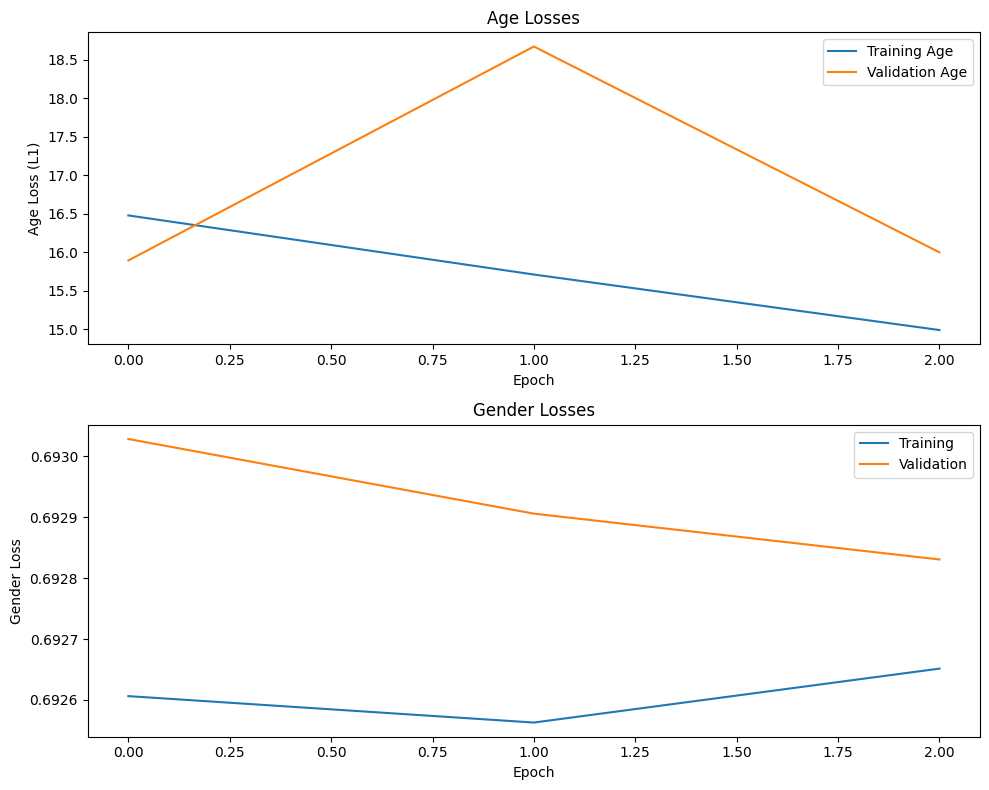

In [ ]:
train_age_losses, train_gender_losses, val_age_losses, val_gender_losses,\
average_val_age_loss, average_val_gender_loss =\
train_nn(
    model,
    train_dataloader,
    optimizer,
    age_criterion,
    gender_criterion,
    scheduler,
    device,
    num_epochs=N_EPOCHS,
    checkpoint_path=CHECK_POINT_PATH,
    patience=2,
)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/data/model_checkpoint5.pth'
checkpoint = torch.load(checkpoint_path)
print('Optimizer: ', checkpoint['optimizer'])
print('Scheduler: ', checkpoint['scheduler'])
print('Summed Validation Loss: ', checkpoint['best_val_age_gender_loss'])
print('Age loss: ', checkpoint['val_age_losses'])
print('Gender loss: ', checkpoint['val_gender_losses'])
print("Average Age Loss: ", checkpoint['average_val_age_loss'])
print("Average Gender Loss: ", checkpoint['average_val_gender_loss'])

Optimizer:  {'state': {159: {'step': 887, 'square_avg': tensor([[3.4749e-05, 7.0769e-05, 4.9006e-05,  ..., 3.6119e-05, 4.8962e-05,
         3.0517e-05],
        [2.4048e-07, 3.0264e-07, 3.0153e-07,  ..., 2.8792e-07, 2.7206e-07,
         2.8398e-07],
        [1.9278e-07, 2.9759e-07, 2.5388e-07,  ..., 2.6827e-07, 2.6837e-07,
         3.1453e-07],
        ...,
        [2.4889e-07, 3.3561e-07, 2.7397e-07,  ..., 3.0469e-07, 2.6864e-07,
         3.1962e-07],
        [2.5707e-07, 3.2202e-07, 2.7344e-07,  ..., 2.9701e-07, 2.6338e-07,
         3.0915e-07],
        [2.4111e-07, 3.2541e-07, 2.9321e-07,  ..., 2.9342e-07, 2.2927e-07,
         3.2421e-07]], device='cuda:0')}, 160: {'step': 887, 'square_avg': tensor([1.7746e-03, 9.7609e-07, 4.3857e-06,  ..., 9.6399e-07, 9.9166e-07,
        2.0503e-06], device='cuda:0')}, 161: {'step': 887, 'square_avg': tensor([[0.0792, 0.0005, 0.0003,  ..., 0.0005, 0.0004, 0.0005]],
       device='cuda:0')}, 162: {'step': 887, 'square_avg': tensor([0.1352], device='

* Next step testing model with unseen images. This function provides a comprehensive evaluation of the model on the test dataset, including loss calculations and predictions for both age and gender.

In [ ]:
model = ResNet50Module(weights="DEFAULT")
model.load_state_dict(checkpoint['model'])

for param in model.parameters():
    param.requires_grad = False

model.to(device)

age_criterion = nn.L1Loss()
gender_criterion = nn.BCELoss()

In [ ]:
test_age_losses, test_gender_losses, predicted_ages, predicted_genders, true_ages, true_genders = test_model_saved(model, test_dataloader, age_criterion, gender_criterion, device)

Testing: 100%|██████████| 296/296 [00:27<00:00, 10.72it/s]

Test Age Loss: 15.8017
Test Gender Loss: 0.6931


* Next I just print out images of 6 random images from test dataset with true and predicted results:

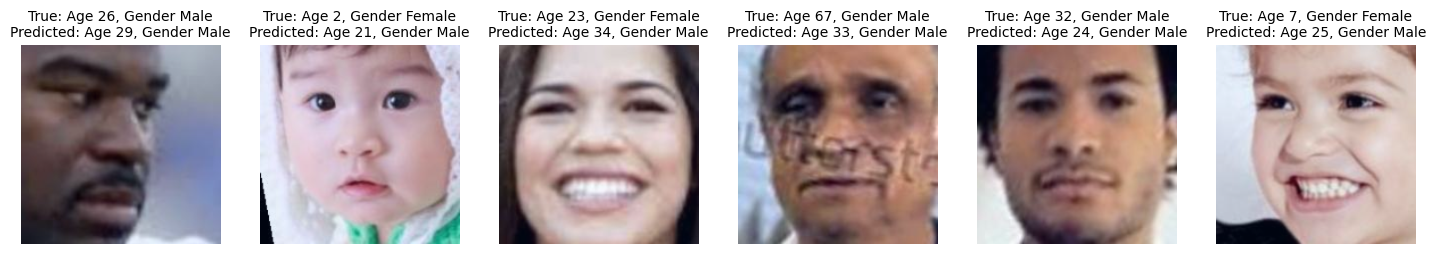

In [ ]:
visualize_predictions(model, test_dataloader, device, age_criterion, gender_criterion)

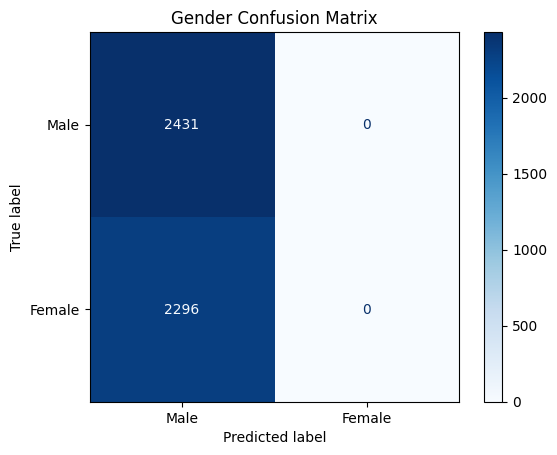


Classification Report - Gender:
              precision    recall  f1-score   support

        Male       0.51      1.00      0.68      2431
      Female       0.00      0.00      0.00      2296

    accuracy                           0.51      4727
   macro avg       0.26      0.50      0.34      4727
weighted avg       0.26      0.51      0.35      4727


DataFrame Gender Predictions:
       True Gender  Predicted Gender
Image                               
0                1                 0
1                1                 0
2                0                 0
3                0                 0
4                1                 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


True Gender  Predicted Gender
Image                               
0                1                 0
1                1                 0
2                0                 0
3                0                 0
4                1                 0
...            ...               ...
4722             1                 0
4723             1                 0
4724             1                 0
4725             1                 0
4726             1                 0

[4727 rows x 2 columns]

In [ ]:
plot_gender_results(model, test_dataloader, gender_criterion, device)

In [ ]:
plot_age_results(model, test_dataloader, age_criterion, device)


L1 Loss - Age: 9.469430923461914
Age Predictions Dataframe
       True Age  Predicted Age  Difference
Image                                     
0            26             27          -1
1            25             28          -3
2            57             37          20
3            52             59          -7
4            32             20          12


True Age  Predicted Age  Difference
Image                                     
0            26             27          -1
1            25             28          -3
2            57             37          20
3            52             59          -7
4            32             20          12
...         ...            ...         ...
4722         21             21           0
4723         29             14          15
4724         27             23           4
4725         50             38          12
4726         63             64          -1

[4727 rows x 3 columns]

* So this is for sure a bad model example, because female gender prediction was not provided after several atempts to tune it.<br>
* My next choice is to change optimizer:

**Second model**:
- Batch size = 8;
- Optimizer  changed to AdamW. Adam is a popular optimization algorithm used to adjust the parameters (weights) of a neural network during training. It combines the advantages of two other optimizers: RMSprop (Root Mean Square Propagation) and Momentum. AdamW introduces weight decay directly into the update step of the Adam optimizer. This helps to improve the stability and convergence of training:<br>
 Learning rate =1e-3<br>
 Weight decay =1e-2 <br>
 Betas = (0.9, 0.999)<br>
Epsilon eps = 1e-8


In [ ]:
BATCH_SIZE = 8
CHECK_POINT_PATH3 = '/content/drive/MyDrive/data/model_checkpoint2.pth'
N_EPOCHS = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = ResNet50Module().to(device=device)

optimizer = AdamW(model3.parameters(), lr=1e-3, weight_decay=1e-2,
                  betas = (0.9, 0.999), eps = 1e-8)

age_criterion = nn.L1Loss()
gender_criterion = nn.BCELoss()

scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
train_dataloader = DataLoader(UTKFace(X_train, y_age_train, y_gender_train),
                              shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(UTKFace(X_val, y_age_val, y_gender_val),
                            shuffle=False, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(UTKFace(X_test, y_age_test, y_gender_test),
                             shuffle=False, batch_size=BATCH_SIZE)

********** Training process started **********


Epoch 1/30 - Training:  11%|█▏        | 201/1773 [00:16<02:09, 12.09it/s]

Training Batch 200 / 1773 - Age Loss L1: 20.9199 - Gender Loss: 0.9889


Epoch 1/30 - Training:  23%|██▎       | 401/1773 [00:33<01:58, 11.54it/s]

Training Batch 400 / 1773 - Age Loss L1: 4.7363 - Gender Loss: 0.6135


Epoch 1/30 - Training:  34%|███▍      | 601/1773 [00:50<01:39, 11.80it/s]

Training Batch 600 / 1773 - Age Loss L1: 15.7849 - Gender Loss: 0.5273


Epoch 1/30 - Training:  45%|████▌     | 801/1773 [01:07<01:20, 12.11it/s]

Training Batch 800 / 1773 - Age Loss L1: 12.5937 - Gender Loss: 0.5926


Epoch 1/30 - Training:  56%|█████▋    | 1001/1773 [01:24<01:03, 12.12it/s]

Training Batch 1000 / 1773 - Age Loss L1: 7.7687 - Gender Loss: 0.5675


Epoch 1/30 - Training:  68%|██████▊   | 1201/1773 [01:41<00:49, 11.53it/s]

Training Batch 1200 / 1773 - Age Loss L1: 13.0611 - Gender Loss: 0.5397


Epoch 1/30 - Training:  79%|███████▉  | 1401/1773 [01:57<00:31, 11.94it/s]

Training Batch 1400 / 1773 - Age Loss L1: 10.7873 - Gender Loss: 0.1972


Epoch 1/30 - Training:  90%|█████████ | 1601/1773 [02:14<00:14, 11.99it/s]

Training Batch 1600 / 1773 - Age Loss L1: 22.0337 - Gender Loss: 0.4009


Epoch 1/30 - Training: 100%|██████████| 1773/1773 [02:29<00:00, 11.88it/s]


Epoch 1/30 - Training Loss (Age)(L1): 12.1266, Training Loss (Gender): 0.5006
********** Validation started **********


100%|██████████| 591/591 [00:45<00:00, 12.85it/s]


Validation Loss (Age) (L1): 10.1535,Validation Loss (Gender): 0.4171
Finished epoch 1/30 - Validation Loss (Age)(L1): 10.1535, Validation Loss (Gender): 0.4171
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint2.pth (Epoch 1)
********** Training process started **********


Epoch 2/30 - Training:  11%|█▏        | 202/1773 [00:17<02:14, 11.70it/s]

Training Batch 200 / 1773 - Age Loss L1: 9.4688 - Gender Loss: 0.4761


Epoch 2/30 - Training:  23%|██▎       | 402/1773 [00:34<01:59, 11.44it/s]

Training Batch 400 / 1773 - Age Loss L1: 11.8120 - Gender Loss: 1.0625


Epoch 2/30 - Training:  34%|███▍      | 602/1773 [00:51<01:36, 12.13it/s]

Training Batch 600 / 1773 - Age Loss L1: 14.3821 - Gender Loss: 0.4905


Epoch 2/30 - Training:  45%|████▌     | 802/1773 [01:08<01:23, 11.61it/s]

Training Batch 800 / 1773 - Age Loss L1: 8.4098 - Gender Loss: 0.2931


Epoch 2/30 - Training:  57%|█████▋    | 1002/1773 [01:24<01:02, 12.30it/s]

Training Batch 1000 / 1773 - Age Loss L1: 6.6476 - Gender Loss: 0.3550


Epoch 2/30 - Training:  68%|██████▊   | 1202/1773 [01:41<00:47, 11.95it/s]

Training Batch 1200 / 1773 - Age Loss L1: 9.4975 - Gender Loss: 0.2491


Epoch 2/30 - Training:  79%|███████▉  | 1402/1773 [01:58<00:31, 11.68it/s]

Training Batch 1400 / 1773 - Age Loss L1: 7.1585 - Gender Loss: 0.5384


Epoch 2/30 - Training:  90%|█████████ | 1602/1773 [02:15<00:14, 11.87it/s]

Training Batch 1600 / 1773 - Age Loss L1: 10.8225 - Gender Loss: 0.4867


Epoch 2/30 - Training: 100%|██████████| 1773/1773 [02:29<00:00, 11.86it/s]


Epoch 2/30 - Training Loss (Age)(L1): 10.7590, Training Loss (Gender): 0.4519
********** Validation started **********


100%|██████████| 591/591 [00:45<00:00, 12.90it/s]


Validation Loss (Age) (L1): 10.2383,Validation Loss (Gender): 0.3894
Finished epoch 2/30 - Validation Loss (Age)(L1): 10.2383, Validation Loss (Gender): 0.3894
********** Training process started **********


Epoch 3/30 - Training:  11%|█▏        | 201/1773 [00:17<02:18, 11.33it/s]

Training Batch 200 / 1773 - Age Loss L1: 7.9627 - Gender Loss: 0.5206


Epoch 3/30 - Training:  23%|██▎       | 401/1773 [00:34<01:58, 11.55it/s]

Training Batch 400 / 1773 - Age Loss L1: 12.3066 - Gender Loss: 0.3240


Epoch 3/30 - Training:  34%|███▍      | 601/1773 [00:51<01:39, 11.82it/s]

Training Batch 600 / 1773 - Age Loss L1: 14.3715 - Gender Loss: 0.2290


Epoch 3/30 - Training:  45%|████▌     | 801/1773 [01:07<01:21, 11.96it/s]

Training Batch 800 / 1773 - Age Loss L1: 9.4530 - Gender Loss: 0.4165


Epoch 3/30 - Training:  56%|█████▋    | 1001/1773 [01:24<01:04, 12.03it/s]

Training Batch 1000 / 1773 - Age Loss L1: 4.3845 - Gender Loss: 0.2029


Epoch 3/30 - Training:  68%|██████▊   | 1201/1773 [01:41<00:49, 11.64it/s]

Training Batch 1200 / 1773 - Age Loss L1: 13.4074 - Gender Loss: 0.0790


Epoch 3/30 - Training:  79%|███████▉  | 1401/1773 [01:58<00:31, 11.67it/s]

Training Batch 1400 / 1773 - Age Loss L1: 7.8959 - Gender Loss: 0.7741


Epoch 3/30 - Training:  90%|█████████ | 1601/1773 [02:15<00:14, 11.61it/s]

Training Batch 1600 / 1773 - Age Loss L1: 13.0195 - Gender Loss: 0.2061


Epoch 3/30 - Training: 100%|██████████| 1773/1773 [02:29<00:00, 11.82it/s]


Epoch 3/30 - Training Loss (Age)(L1): 10.0108, Training Loss (Gender): 0.3991
********** Validation started **********


100%|██████████| 591/591 [00:45<00:00, 12.88it/s]


Validation Loss (Age) (L1): 9.8144,Validation Loss (Gender): 0.3827
Finished epoch 3/30 - Validation Loss (Age)(L1): 9.8144, Validation Loss (Gender): 0.3827
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint2.pth (Epoch 3)
********** Training process started **********


Epoch 4/30 - Training:  11%|█▏        | 201/1773 [00:17<02:07, 12.32it/s]

Training Batch 200 / 1773 - Age Loss L1: 8.2318 - Gender Loss: 0.6580


Epoch 4/30 - Training:  23%|██▎       | 401/1773 [00:34<01:55, 11.87it/s]

Training Batch 400 / 1773 - Age Loss L1: 5.6412 - Gender Loss: 0.2714


Epoch 4/30 - Training:  34%|███▍      | 601/1773 [00:51<01:41, 11.56it/s]

Training Batch 600 / 1773 - Age Loss L1: 9.1767 - Gender Loss: 0.2178


Epoch 4/30 - Training:  45%|████▌     | 801/1773 [01:08<01:19, 12.15it/s]

Training Batch 800 / 1773 - Age Loss L1: 4.3041 - Gender Loss: 0.2959


Epoch 4/30 - Training:  56%|█████▋    | 1001/1773 [01:25<01:05, 11.78it/s]

Training Batch 1000 / 1773 - Age Loss L1: 8.2632 - Gender Loss: 0.2889


Epoch 4/30 - Training:  68%|██████▊   | 1201/1773 [01:41<00:48, 11.74it/s]

Training Batch 1200 / 1773 - Age Loss L1: 14.5871 - Gender Loss: 0.1915


Epoch 4/30 - Training:  79%|███████▉  | 1401/1773 [01:58<00:31, 11.94it/s]

Training Batch 1400 / 1773 - Age Loss L1: 7.9795 - Gender Loss: 0.5285


Epoch 4/30 - Training:  90%|█████████ | 1601/1773 [02:15<00:14, 11.66it/s]

Training Batch 1600 / 1773 - Age Loss L1: 11.1912 - Gender Loss: 0.3840


Epoch 4/30 - Training: 100%|██████████| 1773/1773 [02:30<00:00, 11.77it/s]


Epoch 4/30 - Training Loss (Age)(L1): 9.8427, Training Loss (Gender): 0.3934
********** Validation started **********


100%|██████████| 591/591 [00:46<00:00, 12.85it/s]


Validation Loss (Age) (L1): 9.6390,Validation Loss (Gender): 0.3732
Finished epoch 4/30 - Validation Loss (Age)(L1): 9.6390, Validation Loss (Gender): 0.3732
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint2.pth (Epoch 4)
********** Training process started **********


Epoch 5/30 - Training:  11%|█▏        | 201/1773 [00:17<02:14, 11.65it/s]

Training Batch 200 / 1773 - Age Loss L1: 10.1209 - Gender Loss: 0.3935


Epoch 5/30 - Training:  23%|██▎       | 401/1773 [00:34<01:59, 11.46it/s]

Training Batch 400 / 1773 - Age Loss L1: 13.7165 - Gender Loss: 0.4523


Epoch 5/30 - Training:  34%|███▍      | 601/1773 [00:51<01:41, 11.53it/s]

Training Batch 600 / 1773 - Age Loss L1: 9.1286 - Gender Loss: 0.4050


Epoch 5/30 - Training:  45%|████▌     | 801/1773 [01:08<01:20, 12.01it/s]

Training Batch 800 / 1773 - Age Loss L1: 15.3589 - Gender Loss: 0.1289


Epoch 5/30 - Training:  56%|█████▋    | 1001/1773 [01:25<01:05, 11.83it/s]

Training Batch 1000 / 1773 - Age Loss L1: 8.3766 - Gender Loss: 0.3325


Epoch 5/30 - Training:  68%|██████▊   | 1201/1773 [01:42<00:48, 11.82it/s]

Training Batch 1200 / 1773 - Age Loss L1: 6.8770 - Gender Loss: 0.4823


Epoch 5/30 - Training:  79%|███████▉  | 1401/1773 [01:59<00:31, 11.65it/s]

Training Batch 1400 / 1773 - Age Loss L1: 12.2951 - Gender Loss: 0.3092


Epoch 5/30 - Training:  90%|█████████ | 1601/1773 [02:16<00:14, 11.96it/s]

Training Batch 1600 / 1773 - Age Loss L1: 11.0080 - Gender Loss: 0.3210


Epoch 5/30 - Training: 100%|██████████| 1773/1773 [02:31<00:00, 11.73it/s]


Epoch 5/30 - Training Loss (Age)(L1): 9.6624, Training Loss (Gender): 0.3842
********** Validation started **********


100%|██████████| 591/591 [00:46<00:00, 12.80it/s]


Validation Loss (Age) (L1): 10.0544,Validation Loss (Gender): 0.3662
Finished epoch 5/30 - Validation Loss (Age)(L1): 10.0544, Validation Loss (Gender): 0.3662
********** Training process started **********


Epoch 6/30 - Training:  11%|█▏        | 202/1773 [00:17<02:10, 12.02it/s]

Training Batch 200 / 1773 - Age Loss L1: 12.8131 - Gender Loss: 0.1743


Epoch 6/30 - Training:  23%|██▎       | 402/1773 [00:34<02:01, 11.31it/s]

Training Batch 400 / 1773 - Age Loss L1: 7.0628 - Gender Loss: 0.2330


Epoch 6/30 - Training:  34%|███▍      | 602/1773 [00:51<01:40, 11.62it/s]

Training Batch 600 / 1773 - Age Loss L1: 5.6527 - Gender Loss: 0.5498


Epoch 6/30 - Training:  45%|████▌     | 802/1773 [01:08<01:23, 11.60it/s]

Training Batch 800 / 1773 - Age Loss L1: 9.7701 - Gender Loss: 0.2726


Epoch 6/30 - Training:  57%|█████▋    | 1002/1773 [01:25<01:05, 11.84it/s]

Training Batch 1000 / 1773 - Age Loss L1: 11.4165 - Gender Loss: 0.3858


Epoch 6/30 - Training:  68%|██████▊   | 1202/1773 [01:42<00:49, 11.63it/s]

Training Batch 1200 / 1773 - Age Loss L1: 12.8765 - Gender Loss: 0.1604


Epoch 6/30 - Training:  79%|███████▉  | 1402/1773 [01:59<00:30, 12.01it/s]

Training Batch 1400 / 1773 - Age Loss L1: 6.7965 - Gender Loss: 0.6909


Epoch 6/30 - Training:  90%|█████████ | 1602/1773 [02:16<00:14, 11.93it/s]

Training Batch 1600 / 1773 - Age Loss L1: 9.1180 - Gender Loss: 0.2397


Epoch 6/30 - Training: 100%|██████████| 1773/1773 [02:30<00:00, 11.76it/s]


Epoch 6/30 - Training Loss (Age)(L1): 9.6768, Training Loss (Gender): 0.3783
********** Validation started **********


100%|██████████| 591/591 [00:45<00:00, 12.85it/s]


Validation Loss (Age) (L1): 9.5377,Validation Loss (Gender): 0.3769
Finished epoch 6/30 - Validation Loss (Age)(L1): 9.5377, Validation Loss (Gender): 0.3769
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint2.pth (Epoch 6)
********** Training process started **********


Epoch 7/30 - Training:  11%|█▏        | 201/1773 [00:17<02:11, 11.92it/s]

Training Batch 200 / 1773 - Age Loss L1: 7.9806 - Gender Loss: 0.4173


Epoch 7/30 - Training:  23%|██▎       | 401/1773 [00:34<01:53, 12.04it/s]

Training Batch 400 / 1773 - Age Loss L1: 10.4821 - Gender Loss: 0.3347


Epoch 7/30 - Training:  34%|███▍      | 601/1773 [00:51<01:38, 11.90it/s]

Training Batch 600 / 1773 - Age Loss L1: 6.5150 - Gender Loss: 0.3518


Epoch 7/30 - Training:  45%|████▌     | 801/1773 [01:08<01:24, 11.46it/s]

Training Batch 800 / 1773 - Age Loss L1: 10.0547 - Gender Loss: 0.7233


Epoch 7/30 - Training:  56%|█████▋    | 1001/1773 [01:25<01:07, 11.42it/s]

Training Batch 1000 / 1773 - Age Loss L1: 6.9601 - Gender Loss: 0.1564


Epoch 7/30 - Training:  68%|██████▊   | 1201/1773 [01:42<00:47, 11.95it/s]

Training Batch 1200 / 1773 - Age Loss L1: 14.1331 - Gender Loss: 0.5955


Epoch 7/30 - Training:  79%|███████▉  | 1401/1773 [01:59<00:31, 11.83it/s]

Training Batch 1400 / 1773 - Age Loss L1: 5.0398 - Gender Loss: 0.3888


Epoch 7/30 - Training:  90%|█████████ | 1601/1773 [02:16<00:14, 11.74it/s]

Training Batch 1600 / 1773 - Age Loss L1: 7.7918 - Gender Loss: 0.3284


Epoch 7/30 - Training: 100%|██████████| 1773/1773 [02:30<00:00, 11.77it/s]


Epoch 7/30 - Training Loss (Age)(L1): 9.6553, Training Loss (Gender): 0.3833
********** Validation started **********


100%|██████████| 591/591 [00:46<00:00, 12.76it/s]


Validation Loss (Age) (L1): 9.8876,Validation Loss (Gender): 0.3842
Finished epoch 7/30 - Validation Loss (Age)(L1): 9.8876, Validation Loss (Gender): 0.3842
********** Training process started **********


Epoch 8/30 - Training:  11%|█▏        | 202/1773 [00:17<02:15, 11.57it/s]

Training Batch 200 / 1773 - Age Loss L1: 14.1257 - Gender Loss: 0.3174


Epoch 8/30 - Training:  23%|██▎       | 402/1773 [00:34<01:55, 11.83it/s]

Training Batch 400 / 1773 - Age Loss L1: 5.9936 - Gender Loss: 0.4667


Epoch 8/30 - Training:  34%|███▍      | 602/1773 [00:50<01:37, 11.96it/s]

Training Batch 600 / 1773 - Age Loss L1: 12.0971 - Gender Loss: 0.7081


Epoch 8/30 - Training:  45%|████▌     | 802/1773 [01:07<01:20, 12.02it/s]

Training Batch 800 / 1773 - Age Loss L1: 10.7170 - Gender Loss: 0.4717


Epoch 8/30 - Training:  57%|█████▋    | 1002/1773 [01:24<01:06, 11.65it/s]

Training Batch 1000 / 1773 - Age Loss L1: 9.6951 - Gender Loss: 0.2924


Epoch 8/30 - Training:  68%|██████▊   | 1202/1773 [01:41<00:51, 11.15it/s]

Training Batch 1200 / 1773 - Age Loss L1: 14.1360 - Gender Loss: 0.2032


Epoch 8/30 - Training:  79%|███████▉  | 1402/1773 [01:58<00:30, 12.03it/s]

Training Batch 1400 / 1773 - Age Loss L1: 9.9308 - Gender Loss: 0.0659


Epoch 8/30 - Training:  90%|█████████ | 1602/1773 [02:15<00:14, 11.85it/s]

Training Batch 1600 / 1773 - Age Loss L1: 21.0943 - Gender Loss: 0.2122


Epoch 8/30 - Training: 100%|██████████| 1773/1773 [02:30<00:00, 11.80it/s]


Epoch 8/30 - Training Loss (Age)(L1): 9.6516, Training Loss (Gender): 0.3802
********** Validation started **********


100%|██████████| 591/591 [00:46<00:00, 12.84it/s]


Validation Loss (Age) (L1): 9.5511,Validation Loss (Gender): 0.3723
Finished epoch 8/30 - Validation Loss (Age)(L1): 9.5511, Validation Loss (Gender): 0.3723
Early stopping after 2 epochs without improvement.


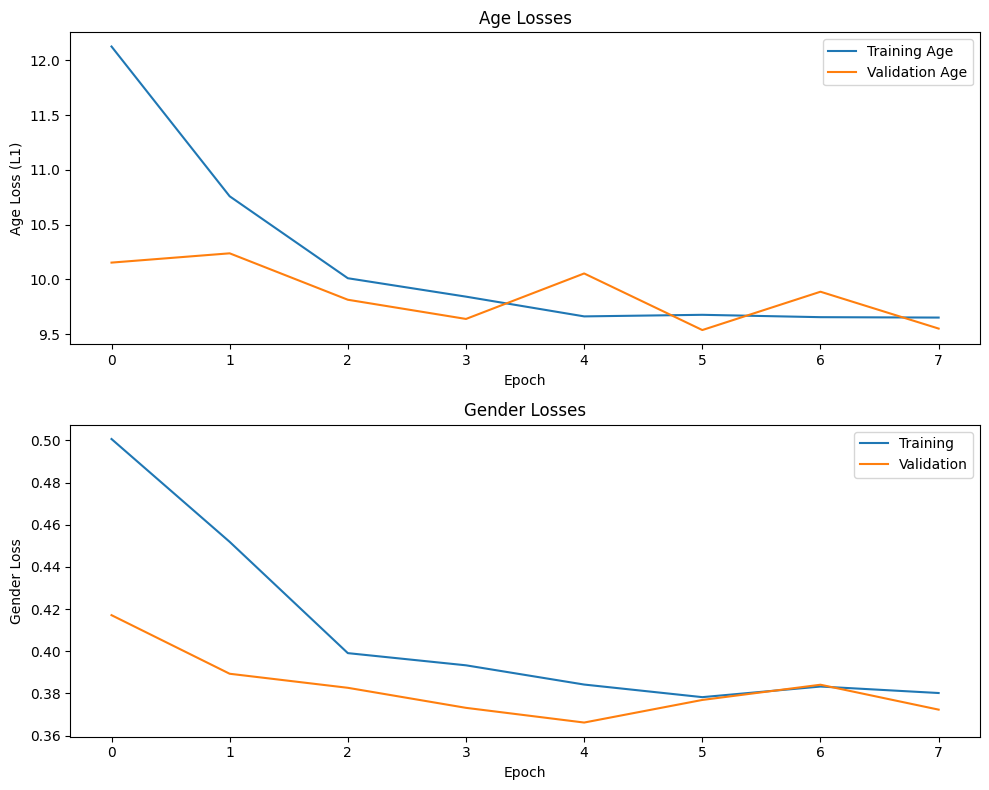

In [ ]:
train_age_losses, train_gender_losses, val_age_losses, val_gender_losses,\
average_val_age_loss, average_val_gender_loss =\
train_nn(
    model3,
    train_dataloader,
    optimizer,
    age_criterion,
    gender_criterion,
    scheduler,
    device,
    num_epochs=N_EPOCHS,
    checkpoint_path=CHECK_POINT_PATH3,
    patience=2,
)

In [ ]:
checkpoint_path3 = '/content/drive/MyDrive/data/model_checkpoint2.pth'
checkpoint3 = torch.load(checkpoint_path3)
print('Summed Validation Loss: ', checkpoint3['best_val_age_gender_loss'])
print('Age loss: ', checkpoint3['val_age_losses'])
print('Gender loss: ', checkpoint3['val_gender_losses'])
print("Average Age Loss: ", checkpoint3['average_val_age_loss'])
print("Average Gender Loss: ", checkpoint3['average_val_gender_loss'])
model3 = ResNet50Module(weights="DEFAULT")
model3.load_state_dict(checkpoint3['model'])

for param in model3.parameters():
    param.requires_grad = False

model3.to(device)

age_criterion = nn.L1Loss()
gender_criterion = nn.BCELoss()

Summed Validation Loss:  9.914657596066947
Age loss:  [10.153491559972618, 10.238269332701785, 9.81439437478932, 9.639034565733573, 10.054367282063827, 9.53771976892113]
Gender loss:  [0.41713060040890465, 0.38935357404088006, 0.3826932200623043, 0.37319170133023194, 0.36622492102953386, 0.3769378271458163]
Average Age Loss:  9.53771976892113
Average Gender Loss:  0.3769378271458163


In [ ]:
test_age_losses, test_gender_losses, predicted_ages, predicted_genders,\
true_ages, true_genders = test_model_saved(model3, test_dataloader,
                                           age_criterion, gender_criterion,
                                           device)

Testing: 100%|██████████| 591/591 [00:45<00:00, 13.03it/s]

Test Age Loss: 9.6892
Test Gender Loss: 0.4032


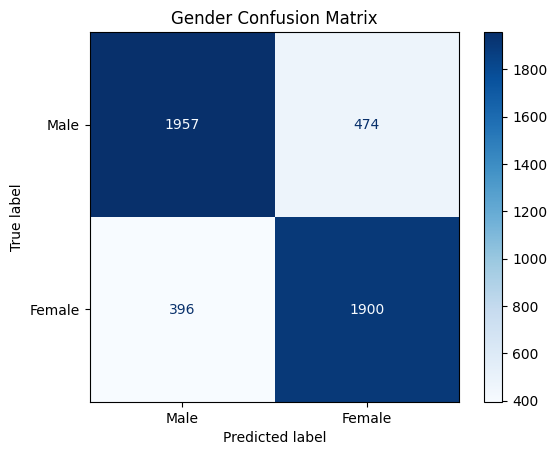


Classification Report - Gender:
              precision    recall  f1-score   support

        Male       0.83      0.81      0.82      2431
      Female       0.80      0.83      0.81      2296

    accuracy                           0.82      4727
   macro avg       0.82      0.82      0.82      4727
weighted avg       0.82      0.82      0.82      4727


DataFrame Gender Predictions:
       True Gender  Predicted Gender
Image                               
0                1                 0
1                1                 1
2                0                 0
3                0                 0
4                1                 1


True Gender  Predicted Gender
Image                               
0                1                 0
1                1                 1
2                0                 0
3                0                 0
4                1                 1
...            ...               ...
4722             1                 1
4723             1                 1
4724             1                 1
4725             1                 1
4726             1                 0

[4727 rows x 2 columns]

In [ ]:
plot_gender_results(model3, test_dataloader, gender_criterion, device)

In [ ]:
plot_age_results(model3, test_dataloader, age_criterion, device)


L1 Loss - Age: 9.472603797912598
Age Predictions Dataframe
       True Age  Predicted Age  Difference
Image                                     
0            26             27          -1
1            25             29          -4
2            57             31          26
3            52             54          -2
4            32             19          13


True Age  Predicted Age  Difference
Image                                     
0            26             27          -1
1            25             29          -4
2            57             31          26
3            52             54          -2
4            32             19          13
...         ...            ...         ...
4722         21             21           0
4723         29             13          16
4724         27             25           2
4725         50             30          20
4726         63             59           4

[4727 rows x 3 columns]

**Third and best Model**:
- Batch size reduced to 16;
- optimizer  AdamW:<br>
Learning_rate =  1e-3,<br>
Weight_decay=1e-5

In [ ]:
BATCH_SIZE = 16
CHECK_POINT_PATH2 = '/content/drive/MyDrive/data/model_checkpoint1.pth'
N_EPOCHS = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = ResNet50Module(weights='DEFAULT').to(device)

optimizer = AdamW(model2.parameters(), lr=1e-3, weight_decay=1e-5)

age_criterion = nn.L1Loss()
gender_criterion = nn.BCELoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
train_dataloader = DataLoader(
    UTKFace(X_train, y_age_train, y_gender_train),
    shuffle=True,
    batch_size=BATCH_SIZE,
)
val_dataloader = DataLoader(
    UTKFace(X_val, y_age_val, y_gender_val),
    shuffle=False,
    batch_size=BATCH_SIZE,
)
test_dataloader = DataLoader(
    UTKFace(X_test, y_age_test, y_gender_test),
    shuffle=False,
    batch_size=BATCH_SIZE,
)

********** Training process started **********


Epoch 1/30 - Training:  23%|██▎       | 200/887 [35:56<2:03:31, 10.79s/it]

Training Batch 200 / 887 - Age Loss L1: 12.9072 - Gender Loss: 0.5743


Epoch 1/30 - Training:  45%|████▌     | 400/887 [1:11:21<1:26:54, 10.71s/it]

Training Batch 400 / 887 - Age Loss L1: 10.6782 - Gender Loss: 0.3348


Epoch 1/30 - Training:  68%|██████▊   | 600/887 [1:47:12<53:20, 11.15s/it]

Training Batch 600 / 887 - Age Loss L1: 15.5813 - Gender Loss: 0.4716


Epoch 1/30 - Training:  90%|█████████ | 800/887 [2:22:53<15:20, 10.58s/it]

Training Batch 800 / 887 - Age Loss L1: 12.6755 - Gender Loss: 0.3055


Epoch 1/30 - Training: 100%|██████████| 887/887 [2:38:31<00:00, 10.72s/it]


Epoch 1/30 - Training Loss (Age)(L1): 12.1300, Training Loss (Gender): 0.4920
********** Validation started **********


100%|██████████| 296/296 [53:46<00:00, 10.90s/it]


Validation Loss (Age) (L1): 10.2752,Validation Loss (Gender): 0.4336
Finished epoch 1/30 - Validation Loss (Age)(L1): 10.2752, Validation Loss (Gender): 0.4336
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint1.pth (Epoch 1)
********** Training process started **********


Epoch 2/30 - Training:  23%|██▎       | 201/887 [00:33<01:49,  6.25it/s]

Training Batch 200 / 887 - Age Loss L1: 12.3398 - Gender Loss: 0.3602


Epoch 2/30 - Training:  45%|████▌     | 401/887 [01:05<01:18,  6.21it/s]

Training Batch 400 / 887 - Age Loss L1: 10.8862 - Gender Loss: 0.3124


Epoch 2/30 - Training:  68%|██████▊   | 601/887 [01:37<00:46,  6.13it/s]

Training Batch 600 / 887 - Age Loss L1: 8.4521 - Gender Loss: 0.6572


Epoch 2/30 - Training:  90%|█████████ | 801/887 [02:10<00:14,  6.06it/s]

Training Batch 800 / 887 - Age Loss L1: 6.6245 - Gender Loss: 0.3687


Epoch 2/30 - Training: 100%|██████████| 887/887 [02:24<00:00,  6.15it/s]


Epoch 2/30 - Training Loss (Age)(L1): 10.2812, Training Loss (Gender): 0.4276
********** Validation started **********


100%|██████████| 296/296 [00:44<00:00,  6.63it/s]


Validation Loss (Age) (L1): 9.6599,Validation Loss (Gender): 0.3986
Finished epoch 2/30 - Validation Loss (Age)(L1): 9.6599, Validation Loss (Gender): 0.3986
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint1.pth (Epoch 2)
********** Training process started **********


Epoch 3/30 - Training:  23%|██▎       | 201/887 [00:33<01:52,  6.10it/s]

Training Batch 200 / 887 - Age Loss L1: 9.2128 - Gender Loss: 0.2730


Epoch 3/30 - Training:  45%|████▌     | 401/887 [01:06<01:17,  6.28it/s]

Training Batch 400 / 887 - Age Loss L1: 9.7259 - Gender Loss: 0.3818


Epoch 3/30 - Training:  68%|██████▊   | 601/887 [01:38<00:45,  6.33it/s]

Training Batch 600 / 887 - Age Loss L1: 12.6643 - Gender Loss: 0.3676


Epoch 3/30 - Training:  90%|█████████ | 801/887 [02:11<00:14,  6.00it/s]

Training Batch 800 / 887 - Age Loss L1: 8.8489 - Gender Loss: 0.3573


Epoch 3/30 - Training: 100%|██████████| 887/887 [02:25<00:00,  6.12it/s]


Epoch 3/30 - Training Loss (Age)(L1): 9.8714, Training Loss (Gender): 0.4017
********** Validation started **********


100%|██████████| 296/296 [00:44<00:00,  6.62it/s]


Validation Loss (Age) (L1): 9.5787,Validation Loss (Gender): 0.4338
Finished epoch 3/30 - Validation Loss (Age)(L1): 9.5787, Validation Loss (Gender): 0.4338
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint1.pth (Epoch 3)
********** Training process started **********


Epoch 4/30 - Training:  23%|██▎       | 201/887 [00:33<01:54,  5.99it/s]

Training Batch 200 / 887 - Age Loss L1: 8.4185 - Gender Loss: 0.3101


Epoch 4/30 - Training:  45%|████▌     | 401/887 [01:05<01:18,  6.18it/s]

Training Batch 400 / 887 - Age Loss L1: 13.2532 - Gender Loss: 0.4091


Epoch 4/30 - Training:  68%|██████▊   | 601/887 [01:38<00:44,  6.37it/s]

Training Batch 600 / 887 - Age Loss L1: 10.2431 - Gender Loss: 0.5847


Epoch 4/30 - Training:  90%|█████████ | 801/887 [02:10<00:14,  6.12it/s]

Training Batch 800 / 887 - Age Loss L1: 9.9049 - Gender Loss: 0.4088


Epoch 4/30 - Training: 100%|██████████| 887/887 [02:24<00:00,  6.12it/s]


Epoch 4/30 - Training Loss (Age)(L1): 9.3472, Training Loss (Gender): 0.3491
********** Validation started **********


100%|██████████| 296/296 [00:45<00:00,  6.57it/s]


Validation Loss (Age) (L1): 9.5061,Validation Loss (Gender): 0.3760
Finished epoch 4/30 - Validation Loss (Age)(L1): 9.5061, Validation Loss (Gender): 0.3760
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint1.pth (Epoch 4)
********** Training process started **********


Epoch 5/30 - Training:  23%|██▎       | 201/887 [00:33<01:47,  6.38it/s]

Training Batch 200 / 887 - Age Loss L1: 9.6602 - Gender Loss: 0.3777


Epoch 5/30 - Training:  45%|████▌     | 401/887 [01:05<01:18,  6.16it/s]

Training Batch 400 / 887 - Age Loss L1: 9.9736 - Gender Loss: 0.5858


Epoch 5/30 - Training:  68%|██████▊   | 601/887 [01:38<00:47,  6.03it/s]

Training Batch 600 / 887 - Age Loss L1: 7.3757 - Gender Loss: 0.3671


Epoch 5/30 - Training:  90%|█████████ | 801/887 [02:10<00:13,  6.30it/s]

Training Batch 800 / 887 - Age Loss L1: 10.4929 - Gender Loss: 0.2450


Epoch 5/30 - Training: 100%|██████████| 887/887 [02:24<00:00,  6.15it/s]


Epoch 5/30 - Training Loss (Age)(L1): 9.2262, Training Loss (Gender): 0.3432
********** Validation started **********


100%|██████████| 296/296 [00:44<00:00,  6.63it/s]


Validation Loss (Age) (L1): 9.4908,Validation Loss (Gender): 0.3823
Finished epoch 5/30 - Validation Loss (Age)(L1): 9.4908, Validation Loss (Gender): 0.3823
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint1.pth (Epoch 5)
********** Training process started **********


Epoch 6/30 - Training:  23%|██▎       | 201/887 [00:33<01:51,  6.17it/s]

Training Batch 200 / 887 - Age Loss L1: 10.7516 - Gender Loss: 0.1722


Epoch 6/30 - Training:  45%|████▌     | 401/887 [01:05<01:16,  6.34it/s]

Training Batch 400 / 887 - Age Loss L1: 7.3196 - Gender Loss: 0.2984


Epoch 6/30 - Training:  68%|██████▊   | 601/887 [01:38<00:47,  6.08it/s]

Training Batch 600 / 887 - Age Loss L1: 5.2893 - Gender Loss: 0.4834


Epoch 6/30 - Training:  90%|█████████ | 801/887 [02:10<00:13,  6.16it/s]

Training Batch 800 / 887 - Age Loss L1: 12.6794 - Gender Loss: 0.3005


Epoch 6/30 - Training: 100%|██████████| 887/887 [02:24<00:00,  6.14it/s]


Epoch 6/30 - Training Loss (Age)(L1): 9.1554, Training Loss (Gender): 0.3303
********** Validation started **********


100%|██████████| 296/296 [00:44<00:00,  6.61it/s]


Validation Loss (Age) (L1): 9.3931,Validation Loss (Gender): 0.3620
Finished epoch 6/30 - Validation Loss (Age)(L1): 9.3931, Validation Loss (Gender): 0.3620
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint1.pth (Epoch 6)
********** Training process started **********


Epoch 7/30 - Training:  23%|██▎       | 201/887 [00:33<01:50,  6.19it/s]

Training Batch 200 / 887 - Age Loss L1: 8.9762 - Gender Loss: 0.5417


Epoch 7/30 - Training:  45%|████▌     | 401/887 [01:05<01:20,  6.00it/s]

Training Batch 400 / 887 - Age Loss L1: 11.2787 - Gender Loss: 0.5149


Epoch 7/30 - Training:  68%|██████▊   | 601/887 [01:38<00:46,  6.09it/s]

Training Batch 600 / 887 - Age Loss L1: 8.8063 - Gender Loss: 0.2678


Epoch 7/30 - Training:  90%|█████████ | 801/887 [02:10<00:13,  6.19it/s]

Training Batch 800 / 887 - Age Loss L1: 7.6160 - Gender Loss: 0.4921


Epoch 7/30 - Training: 100%|██████████| 887/887 [02:24<00:00,  6.15it/s]


Epoch 7/30 - Training Loss (Age)(L1): 9.0875, Training Loss (Gender): 0.3250
********** Validation started **********


100%|██████████| 296/296 [00:45<00:00,  6.55it/s]


Validation Loss (Age) (L1): 9.2656,Validation Loss (Gender): 0.3623
Finished epoch 7/30 - Validation Loss (Age)(L1): 9.2656, Validation Loss (Gender): 0.3623
Model checkpointed at /content/drive/MyDrive/data/model_checkpoint1.pth (Epoch 7)
********** Training process started **********


Epoch 8/30 - Training:  23%|██▎       | 201/887 [00:33<01:49,  6.28it/s]

Training Batch 200 / 887 - Age Loss L1: 8.6544 - Gender Loss: 0.2188


Epoch 8/30 - Training:  45%|████▌     | 401/887 [01:06<01:21,  5.94it/s]

Training Batch 400 / 887 - Age Loss L1: 5.7045 - Gender Loss: 0.2367


Epoch 8/30 - Training:  68%|██████▊   | 601/887 [01:38<00:46,  6.11it/s]

Training Batch 600 / 887 - Age Loss L1: 12.0040 - Gender Loss: 0.4049


Epoch 8/30 - Training:  90%|█████████ | 801/887 [02:11<00:14,  6.14it/s]

Training Batch 800 / 887 - Age Loss L1: 8.1948 - Gender Loss: 0.4108


Epoch 8/30 - Training: 100%|██████████| 887/887 [02:24<00:00,  6.12it/s]


Epoch 8/30 - Training Loss (Age)(L1): 9.0378, Training Loss (Gender): 0.3257
********** Validation started **********


100%|██████████| 296/296 [00:44<00:00,  6.64it/s]


Validation Loss (Age) (L1): 9.3810,Validation Loss (Gender): 0.3676
Finished epoch 8/30 - Validation Loss (Age)(L1): 9.3810, Validation Loss (Gender): 0.3676
********** Training process started **********


Epoch 9/30 - Training:  23%|██▎       | 201/887 [00:32<01:50,  6.21it/s]

Training Batch 200 / 887 - Age Loss L1: 6.8397 - Gender Loss: 0.2748


Epoch 9/30 - Training:  45%|████▌     | 401/887 [01:04<01:20,  6.07it/s]

Training Batch 400 / 887 - Age Loss L1: 10.6266 - Gender Loss: 0.2577


Epoch 9/30 - Training:  68%|██████▊   | 601/887 [01:37<00:46,  6.17it/s]

Training Batch 600 / 887 - Age Loss L1: 8.0719 - Gender Loss: 0.4927


Epoch 9/30 - Training:  90%|█████████ | 801/887 [02:10<00:13,  6.21it/s]

Training Batch 800 / 887 - Age Loss L1: 8.0903 - Gender Loss: 0.2024


Epoch 9/30 - Training: 100%|██████████| 887/887 [02:24<00:00,  6.15it/s]


Epoch 9/30 - Training Loss (Age)(L1): 9.0907, Training Loss (Gender): 0.3236
********** Validation started **********


100%|██████████| 296/296 [00:45<00:00,  6.56it/s]


Validation Loss (Age) (L1): 9.3491,Validation Loss (Gender): 0.3650
Finished epoch 9/30 - Validation Loss (Age)(L1): 9.3491, Validation Loss (Gender): 0.3650
Early stopping after 2 epochs without improvement.


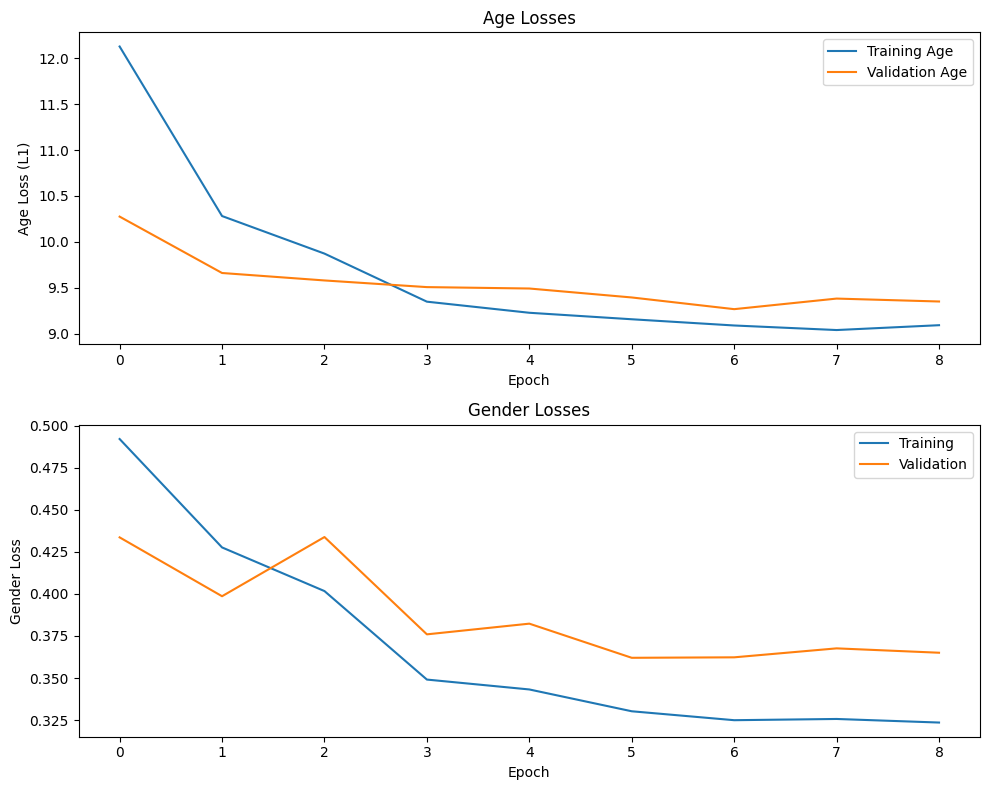

In [ ]:
train_age_losses, train_gender_losses, val_age_losses, val_gender_losses,\
average_val_age_loss, average_val_gender_loss =\
train_nn(
    model2,
    train_dataloader,
    optimizer,
    age_criterion,
    gender_criterion,
    scheduler,
    device,
    num_epochs=N_EPOCHS,
    checkpoint_path=CHECK_POINT_PATH2,
    patience=2,
)

In [ ]:
checkpoint_path2 = '/content/drive/MyDrive/data/model_checkpoint1.pth'
checkpoint2 = torch.load(checkpoint_path2)
print('Summed Validation Loss: ', checkpoint2['best_val_age_gender_loss'])
print('Age loss: ', checkpoint2['val_age_losses'])
print('Gender loss: ', checkpoint2['val_gender_losses'])
print("Average Age Loss: ", checkpoint2['average_val_age_loss'])
print("Average Gender Loss: ", checkpoint2['average_val_gender_loss'])
model2 = ResNet50Module(weights="DEFAULT")
model2.load_state_dict(checkpoint2['model'])

for param in model2.parameters():
    param.requires_grad = False

model2.to(device)

age_criterion = nn.L1Loss()
gender_criterion = nn.BCELoss()

Summed Validation Loss:  9.627908325879961
Age loss:  [10.275175850133639, 9.659939414746052, 9.57869030333854, 9.506065961476919, 9.49078716458501, 9.393144953089791, 9.265606965567615]
Gender loss:  [0.4335688027377064, 0.3985983385024844, 0.4337599070591701, 0.3759539031952217, 0.3823062892046732, 0.36202084701004866, 0.3623013603123459]
Average Age Loss:  9.265606965567615
Average Gender Loss:  0.3623013603123459


In [ ]:
test_age_losses, test_gender_losses, predicted_ages, predicted_genders,\
true_ages, true_genders = test_model_saved(model2, test_dataloader,
                                           age_criterion, gender_criterion,
                                           device)

Testing: 100%|██████████| 296/296 [54:00<00:00, 10.95s/it]

Test Age Loss: 9.4597
Test Gender Loss: 0.3906


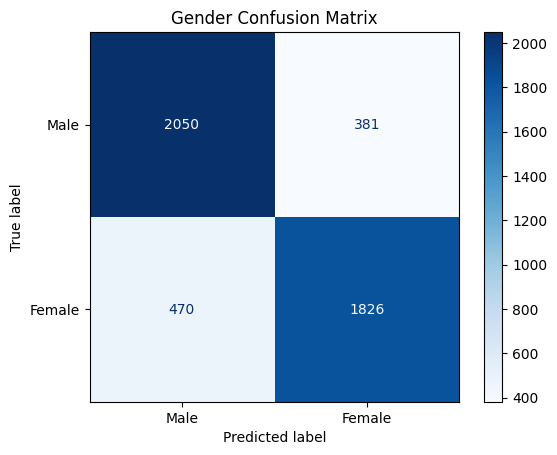


Classification Report - Gender:
              precision    recall  f1-score   support

        Male       0.81      0.84      0.83      2431
      Female       0.83      0.80      0.81      2296

    accuracy                           0.82      4727
   macro avg       0.82      0.82      0.82      4727
weighted avg       0.82      0.82      0.82      4727


DataFrame Gender Predictions:
       True Gender  Predicted Gender
Image                               
0                1                 0
1                1                 1
2                0                 0
3                0                 0
4                1                 1


True Gender  Predicted Gender
Image                               
0                1                 0
1                1                 1
2                0                 0
3                0                 0
4                1                 1
...            ...               ...
4722             1                 1
4723             1                 1
4724             1                 0
4725             1                 1
4726             1                 0

[4727 rows x 2 columns]

In [ ]:
plot_gender_results(model2, test_dataloader, gender_criterion, device)

In [ ]:
age_results_df = plot_age_results(model2, test_dataloader,
                                  age_criterion, device)


L1 Loss - Age: 9.453776359558105
Age Predictions Dataframe
       True Age  Predicted Age  Difference
Image                                     
0            26             33          -7
1            25             30          -5
2            57             35          22
3            52             71         -19
4            32             18          14


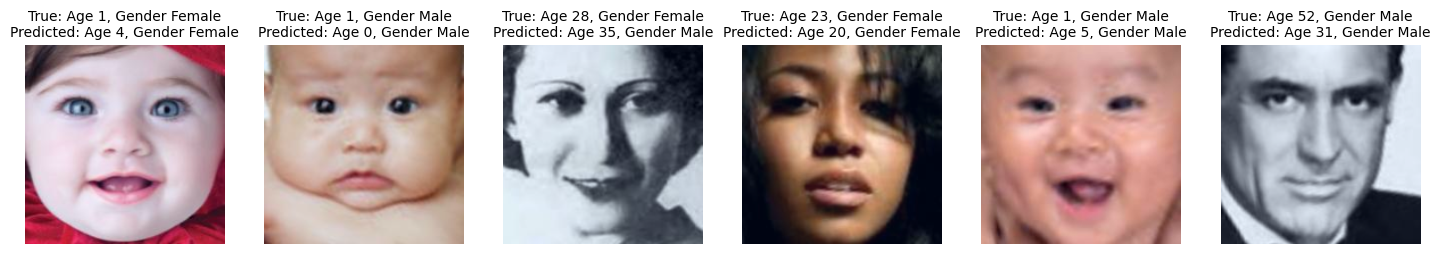

In [ ]:
visualize_predictions(model2, test_dataloader, device,
                      age_criterion, gender_criterion)

**Conclusions:**
The first model with RMSprop optimizer performed poorely and due to the lack of computational resources I made a choice to change optimizer into AdamW.<br>
The third model provided better results than the second one. That is why I will check some highest age predictions mismatch and try to receive some insights.

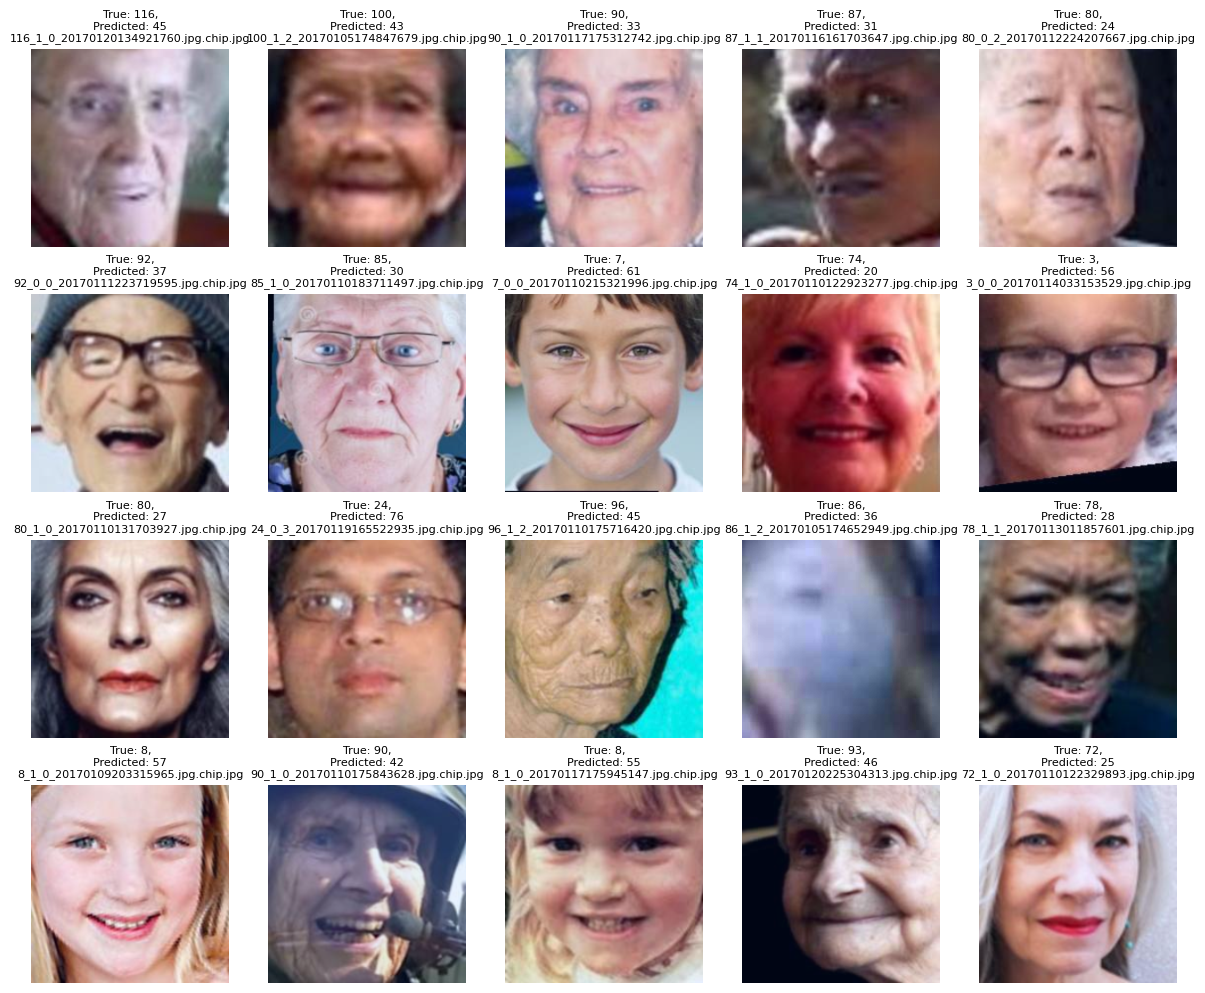

In [ ]:
index_to_path = {i: path for i, path in enumerate(X_test)}
top_diff_df = age_results_df.loc[
    age_results_df["Difference"].abs().sort_values(ascending=False).index[:20]
]

fig = plt.figure(figsize=(12, 10))
for i, (index, row) in enumerate(top_diff_df.iterrows()):
    image_path = index_to_path[index]
    image_title = os.path.basename(image_path)
    image = test_dataloader.dataset[index]["image"].numpy().transpose((1, 2, 0))
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.title(
        f"True: {row['True Age']},\nPredicted: {row['Predicted Age']}\n"
        f"{image_title}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

**Insights of incorrect top 20 predictions:**<br>
* Most images are very blurry and one in particular is impossible to recognize a face;
* Images are mostly of elderly people and from our EDA part we see that there are some groups that were not covered enough for both genders, and there were not enough images for each age group.
* Interestingly smiling faces were predicted of a much younger age.
* Make-up wearing could also provide rejuvenating effect.
* Talking about children age mismatch - it could be that again, not enough images for certain age groups.

* Local Interpretable Model-agnostic Explanations (LIME) will help us understand our neural model.We will see where model focuses while making predictions for gender. The colored area shows image parts used to represent both positive and negative contributions to the predicted class. The image bellow was predicted correctly:

In [ ]:
model2.eval()
true_genders = []
predicted_genders = []
true_ages = []
predicted_ages = []
images = []
with torch.no_grad():
    for data in test_dataloader.dataset:
        image = data["image"].unsqueeze(0).to(device)
        true_age = data['age']
        true_gender = data["gender"]

        true_ages.append(true_age)
        true_genders.append(true_gender)

        age_output, gender_output = model2(image)

        image_np = image.squeeze(0).cpu().numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        image_np = (image_np - np.min(image_np)) / (
            np.max(image_np) - np.min(image_np)
        )
        images.append(image_np)

        predicted_ages.append(int(age_output))
        predicted_genders.append(1 if gender_output.item() >= 0.5 else 0)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Overlay')

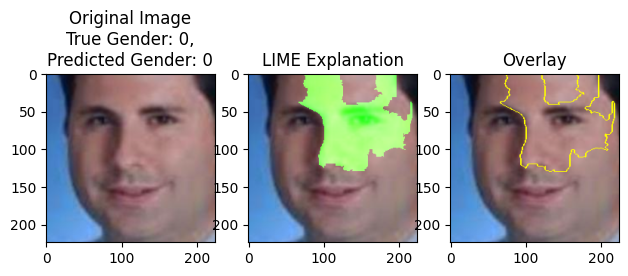

In [ ]:
image_index = 219
image_original = images[image_index]
explainer = lime_image_module.LimeImageExplainer()

def predict_fn(images):
    """Function to predict the gender using the provided model"""
    images = torch.Tensor(images).permute(0, 3, 1, 2).to(device)
    model2.eval()
    with torch.no_grad():
        _, gender_output = model2(images)
    return gender_output.cpu().numpy()

explanation = explainer.explain_instance(
    image_original,
    predict_fn,
    top_labels=1,
    hide_color=0,
)

lime_image_result, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
)

plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(image_original)
plt.title(f'Original Image\nTrue Gender: {true_genders[image_index]},\n'
          f'Predicted Gender: {predicted_genders[image_index]}')

plt.subplot(1, 4, 2)
plt.imshow(lime_image_result)
plt.title('LIME Explanation')

plt.subplot(1, 4, 3)
plt.imshow(mark_boundaries(image_original, mask))
plt.title('Overlay')

* This part Lime explains images, that were predicted incorrectly with biggest ag difference:

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

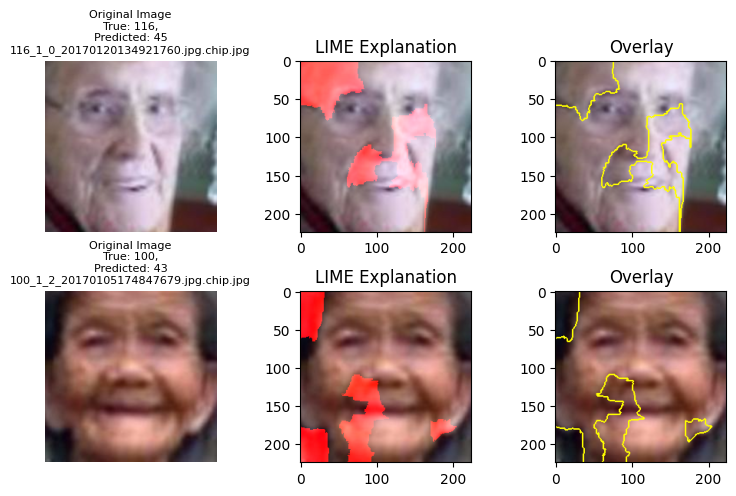

In [ ]:
index_to_path = {i: path for i, path in enumerate(X_test)}
top_diff_df = age_results_df.loc[
    age_results_df["Difference"].abs().sort_values(ascending=False).index[:2]
]

fig = plt.figure(figsize=(10, 5))

for i, (index, row) in enumerate(top_diff_df.iterrows()):
    image_path = index_to_path[index]
    image_title = os.path.basename(image_path)
    image = test_dataloader.dataset[index]["image"].numpy().transpose((1, 2, 0))
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    explainer = lime_image_module.LimeImageExplainer()

    def predict_fn(images):
        """Function to predict the age using the provided model"""
        images = torch.Tensor(images).permute(0, 3, 1, 2).to(device)
        model2.eval()
        with torch.no_grad():
            age_output, _ = model2(images)
        return age_output.cpu().numpy()

    explanation = explainer.explain_instance(
        image,
        predict_fn,
        top_labels=1,
        hide_color=0,
    )

    lime_image_result, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        hide_rest=False,
    )

    plt.subplot(len(top_diff_df), 4, 4 * i + 1)
    plt.imshow(image)
    plt.title(
        f"Original Image\nTrue: {row['True Age']},\n"
        f"Predicted: {row['Predicted Age']}\n"
        f"{image_title}", fontsize=8)
    plt.axis("off")

    plt.subplot(len(top_diff_df), 4, 4 * i + 2)
    plt.imshow(lime_image_result)
    plt.title('LIME Explanation')

    plt.subplot(len(top_diff_df), 4, 4 * i + 3)
    plt.imshow(mark_boundaries(image, mask))
    plt.title('Overlay')

plt.tight_layout()
plt.show()

Looking at the representation of the false age prediction, we can see the following trends:
* the model mispredicts the years of older people. This could be explained by the fact that the available number of photos does not equally represent all age groups;
* a similar rule applies to the age groups of children;
* we did not look at the racial distribution, so we can only speculate whether the racial aspect had an impact on the model results.

In any case, I would conclude that the identification of age, sex or race is itself a very sensitive ethical issue. I think that the model would benefit not only from an even distribution of gender, age and race photos, but also from an even representation of emotions (smiles, anger, indifference), various accessories (like glasses, hats, scarfs).

I think this type of model could be used  in applications such as age and gender estimation for entertainment, customer analytics, or personalized services where privacy and ethical considerations are addressed.
But I would not recommend using it in critical decision-making processes (hiring, banking). Without thorough validation may lead to harmful consequences.

Improvements:
* modelling requires further work on the challenges of image classification and regression;
* it might be worth using weights for value classification;
* for different tasks, it might be useful to use different optimisers;